In [52]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import nltk as nltk
import math

import os
import cProfile, pstats, io
#import memory_profiler
import psutil

import gc

# Enabling eager execution 

In [53]:
tf.enable_eager_execution()
process = psutil.Process(os.getpid())

In [54]:
print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB
#https://stackoverflow.com/questions/938733/total-memory-used-by-python-process

#https://pypi.org/project/memory-profiler/ - did not use it

4403.31640625 MB


# Load Google vectors

In [55]:
UNK = '</s>'

dirname = os.getcwd()
googlePath = os.path.join(dirname, 'datasets/')
outfile = googlePath +'google_word_corpus.pic'

with open(outfile, 'rb') as pickle_file:    
    googleCorpus, google_corpus_word_to_int, google_corpus_int_to_word = pickle.load(pickle_file)
googleSet = pd.read_csv(googlePath+'GoogleNews-vectors-negative10.txt', sep=' ', header=None)
print(googleSet.shape)
print(googleSet.head())

googleWords = googleSet.iloc[:,0:1]
googleVectors = googleSet.iloc[:,1:]

(1965717, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 -0.018799 -0.007111 -0.139648 -0.046631   
3     $  0.113770 -0.117676  0.064941  0.132812  0.054932 -0.099121  0.071289   
4   ###  0.149414 -0.191406  0.044189  0.104980  0.016846 -0.135742 -0.085449   

         8         9         10  
0 -0.000420 -0.000576  0.001076  
1 -0.077637  0.199219 -0.001770  
2 -0.063965  0.098145  0.135742  
3 -0.013306  0.271484 -0.083984  
4  0.074219  0.088867 -0.044922  


In [56]:
#UNK = '<unk>'

#glovePath = '/media/kandy/hdd/master-thesis/datasets/'
#outfile = glovePath +'glove_word_corpus.pic'

#with open(outfile, 'rb') as pickle_file:    
#    gloveCorpus, glove_corpus_word_to_int, glove_corpus_int_to_word = pickle.load(pickle_file)
#gloveSet = pd.read_csv(glovePath+'glove.42B.10d.txt', sep=' ', header=None)
#print(gloveSet.shape)
#print(gloveSet.head())

#gloveWords = gloveSet.iloc[:,0:1]
#gloveVectors = gloveSet.iloc[:,1:]

# Load training and test dataset

In [57]:
#treeDataframe = pd.read_csv(googlePath+'constituency-parsing-data-all-UNK.csv', sep=' ', header=None )
treeDataframe = pd.read_csv(googlePath+'constituency-parsing-data-all-UNK-less-40-words.csv', sep=' ', header=None )

treeDataframe.columns =['sentence', 'tree']
treeDataframe['tree'] = treeDataframe['tree'].apply(nltk.Tree.fromstring)

treeDataframe.head()

,sentence,tree
0,foresight,[[[foresight]]]
1,</s>,[[[daffynition]]]
2,municipals,[[[municipals]]]
3,</s>,[[[daffynition]]]
4,copper,[[[copper]]]


In [58]:
def convert_imdb_corpus_into_int(sentence):
    words = sentence.split()
    words_to_num = [google_corpus_word_to_int[word] for word in words]
    return words_to_num

treeDataframe_num = treeDataframe.copy()
treeDataframe_num['sentence'] = treeDataframe_num['sentence'].apply(convert_imdb_corpus_into_int)
treeDataframe_num.head()

,sentence,tree
0,[1310766],[[[foresight]]]
1,[920150],[[[daffynition]]]
2,[1366184],[[[municipals]]]
3,[920150],[[[daffynition]]]
4,[1188632],[[[copper]]]


In [59]:
treeDF_train, treeDF_test = sklearn.model_selection.train_test_split(treeDataframe_num, test_size=0.2)
print(treeDF_train.shape)
print(treeDF_test.shape)

(35067, 2)
(8767, 2)


In [60]:
#treeDF_train = treeDataframe_num.iloc[treeDataframe_num.shape[0]-50:treeDataframe_num.shape[0]]
#treeDF_test = treeDataframe_num.iloc[0:treeDataframe_num.shape[0]-50]
#print(treeDF_train.shape)
#print(treeDF_test.shape)

# Model and the Parameters

In [61]:
STATE_SIZE = 10
embeddings = tfe.Variable(name='embeddings', validate_shape= googleVectors.shape, 
                          initial_value=googleVectors.values, 
                          dtype=tf.float32, trainable=False)
w = tfe.Variable(name='w', validate_shape=(2*googleVectors.shape[1], STATE_SIZE), 
                 initial_value=0.01 * tf.random_normal(shape=(2*googleVectors.shape[1], STATE_SIZE)),
                 dtype=tf.float32)
b = tfe.Variable(name='b', validate_shape=(1, STATE_SIZE),
                 initial_value=0.01 * tf.random_normal(shape=(1, STATE_SIZE)),
                 dtype=tf.float32)

w_score = tfe.Variable(name='w_score', validate_shape=(STATE_SIZE, 1), 
                 initial_value=0.01 * tf.random_normal(shape=(STATE_SIZE, 1)),
                 dtype=tf.float32)
b_score = tfe.Variable(name='b_score', validate_shape=(1, 1),
                 initial_value=0.01 * tf.random_normal(shape=(1, 1)),
                 dtype=tf.float32)

#print(w)
#print(b)
#print(w_score)
#print(b_score)

In [62]:
print(embeddings.shape)
lookup = tf.nn.embedding_lookup(embeddings, google_corpus_word_to_int['</s>'])
lookup = tf.reshape(lookup, shape=(1, lookup.shape[0]))
print(lookup)

(1965717, 10)
tf.Tensor(
[[ 0.09570312 -0.03881836  0.05883789  0.03930664 -0.01300049 -0.1484375
   0.07568359 -0.13378906  0.2890625   0.00370789]], shape=(1, 10), dtype=float32)


In [63]:
def compute_score_for_tree(tree, weights, embeddings, scores):
    if(type(tree[0]) == type('a string')):
        #print(tree.label() + ' : ' + tree[0])
        word = tree[0].lower()
        if(word not in google_corpus_word_to_int):
            #print('missing word:',word)
            word = '</s>'
        word_vector = tf.nn.embedding_lookup(embeddings, google_corpus_word_to_int[word])
        word_vector = tf.reshape(word_vector, shape=(1, word_vector.shape[0]))
        return word_vector
        #print('depth is reached !!!')
        #return

    #for i in range(len(tree)):
    #    print('Inside tree : '+ tree[i].label())
    #    compute_score_for_tree(tree[i], weights, embeddings)


        
    left = compute_score_for_tree(tree[0], weights, embeddings, scores)
    if(len(tree) !=2):
        return left

    right = compute_score_for_tree(tree[1], weights, embeddings, scores)
    words_concat = tf.concat([left, right], axis=0)
    #print(words_concat.shape)
    #print(left.shape, right.shape)
    words_concat = tf.reshape(words_concat, shape=(1, left.shape[1] + right.shape[1]))
    #print(words_concat)
    z = tf.matmul(words_concat, weights[0]) + weights[1]
    state_vec = tf.tanh(z)
    
    #print(state_vec)
    score = tf.matmul(state_vec, weights[2]) + weights[3]
    scores.append(score)
    return state_vec
    
    
for j in range(treeDF_train.shape[0]):
    tree = treeDF_train.iat[j,1]
    print(tree.leaves())
    scores = []
    tree.chomsky_normal_form()
    compute_score_for_tree(tree[0], [w,b,w_score,b_score], embeddings, scores)
    #print(sum(scores))
    total_score = tf.reduce_sum(tf.stack(scores))
    print(total_score)
    break
    


['if', 'you', 'force', 'financial', 'planners', 'to', 'sum', 'up', 'their', 'most', 'important', 'advice', 'in', 'a', 'single', 'sentence', '</s>', 'it', 'would', 'probably', 'be', 'a', 'one-word', 'sentence', '</s>', '*', 'diversify', '</s>']
tf.Tensor(-0.1738835, shape=(), dtype=float32)


In [64]:
def compare_trees(actual, predicted):
    actual_sub_trees = actual.subtrees()
    
    
    total_count = 0.0 #len(actual_sub_trees)
    match_count = 0.0
    
    for sub_tree in actual_sub_trees:
        #print('Sub Tree:', sub_tree)
        #print(predicted_sub_trees)
        predicted_sub_trees = predicted.subtrees()
        for temp_tree in predicted_sub_trees:
            #print(' ', temp_tree)
            if(sub_tree == temp_tree):
                match_count = match_count + 1.0
                break
        total_count = total_count + 1.0
        #break
    #print('Match:', match_count,' Total:', total_count)
    
    return [match_count/total_count, match_count, total_count]

#compare_trees(treeDF_train.iat[2,1], treeDF_train.iat[2,1])

t1 = nltk.Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
sub_trees = t1.subtrees()
for sub_tree in sub_trees:
    print(sub_tree)

(S (NP I) (VP (V saw) (NP him)))
(NP I)
(VP (V saw) (NP him))
(V saw)
(NP him)


In [65]:
#t1 = nltk.Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
#t2 = nltk.Tree.fromstring("(a (b I) (c (d saw) (e him)))")

#compare_trees(t1, t2)

In [66]:
pr = cProfile.Profile()
pr.enable()
# ... do something ...

In [67]:
def embedding_lookup(input_words):
    words = tf.nn.embedding_lookup(embeddings, input_words)
    return words

def forward_propagation(data):
    
    total_loss_list = []
    total_train_accuracy = 0.0
    total_train_count = 0.0

    for j in range(data.shape[0]):
        # get the word vectors based on the word ids (word id for each word)
        
        words = embedding_lookup(data.iat[j,0])

        end = timer()
        #print('Time taken to lookup embeddings (seconds): ', end-start)
        #words matrix - unstack
        words_unstack = tf.unstack(words)
        words_len = len(words_unstack)

        pred_score_list = []
        predicted_tree = [nltk.Tree(UNK,[google_corpus_int_to_word[index]]) for index in data.iat[j,0]]

        state_vec_list = []
        score_list = []

        start_k = 0
        stop_k = words_len - 1 
        #loop until all the words are merged together
        while(words_len > 1):
            #compute scores for the list of word combinations
            # for each word combination compute the score of it

            scores = np.zeros(shape=(words_len-1, 1))
            for k in range(start_k, stop_k):
                words_concat = tf.concat([words_unstack[k], words_unstack[k+1]], axis=0)
                #reshape the tensor to be a matrix with 1 row rather than vector
                words_concat = tf.reshape(words_concat, shape=(1, words_concat.shape[0]))
                # matrix computation and activation
                z = tf.matmul(words_concat, w) + b
                state_vec = tf.tanh(z)
                state_vec_list.append(state_vec)
                score = tf.matmul(state_vec, w_score) + b_score
                score_list.append(score)
                scores[k] = score

            end = timer()
            #print('Time taken to calculate all subsequent word combinations (seconds): ', end-start)

            #compare the scores and pick the maximum one. 
            max_score_index = np.argmax(scores) 
            pred_score_list.append(scores[max_score_index])

            # remove the words which is used to combine and replace with combined state vector
            words_unstack.pop(max_score_index+1)
            words_unstack.pop(max_score_index)
            # statevector needs to be reshaped as matrix to update
            state_vec_vector = tf.reshape(state_vec, shape = [state_vec.shape[1]])
            words_unstack.insert(max_score_index, state_vec_vector)
            words_len = len(words_unstack)

            right_tree = predicted_tree.pop(max_score_index+1)
            left_tree = predicted_tree.pop(max_score_index)
            predicted_tree.insert(max_score_index, nltk.Tree(UNK, [left_tree, right_tree]))

            start_k = max(0, max_score_index - 1)
            stop_k = min(max_score_index+2, words_len-1)

            #print([max_score_index, start_k, stop_k, words_len])

            end = timer()
            #print('Time taken to make one decision (seconds): ', end-start)

        end = timer()
        if (j%10 == 0):
            print(j,end-start, process.memory_info().rss / (1024*1024), 'MB')
        #if (epoch_arg%10 == 0):
        
        #print('Time taken to forward loop (seconds): ', end-start)
        # get the actual tree - convert it to chomsky normal form, and compute the score
        act_score_list = []
        tree = data.iat[j,1]
        tree.chomsky_normal_form()
        compute_score_for_tree(tree[0], [w,b,w_score,b_score], embeddings, act_score_list)
        end = timer()
        #print('Time taken to chomsky calculation (seconds): ', end-start)

        # compute the total actual and predicted score. use the loss function as absolute difference
        # the above is done for each training data and the loss are accumulated
        total_act_score = tf.reduce_sum(tf.stack(act_score_list))
        total_pred_score = tf.reduce_sum(tf.stack(pred_score_list))
        loss = tf.losses.absolute_difference(total_act_score,  total_pred_score)
        total_loss_list.append(loss)

        #loss = tf.losses.sigmoid_cross_entropy(tf.constant(imdb_train.iat[j,1], shape=(1,1)), y_predict)
        
        total_train_accuracy = total_train_accuracy + compare_trees(tree[0], predicted_tree[0])[0]
        total_train_count = total_train_count + 1
    return total_loss_list, total_train_accuracy/total_train_count



In [68]:
start = timer()
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
epoch = 5

# history to maintain variables,  losses and gradients
variables_history = []
variables_history.append([np.copy(w.numpy()), np.copy(b.numpy()),np.copy(w_score.numpy()),np.copy(b_score.numpy())])

loss_history = []
grad_history = []

mini_batch_size = 50.0
with tf.device("/cpu:0"):
    for i in range(epoch):
        # to record the history of tensor computations
       
        print('Epoch : ', i)
        mini_batch_count = treeDF_train.shape[0] / mini_batch_size
        mini_batch_count = math.ceil(mini_batch_count)
        
        for j in range(mini_batch_count):
            
            print('Minibatch : ', j)
            mini_start = int(j*mini_batch_size)
            mini_stop = int(mini_start + mini_batch_size)
            mini_stop =  min(mini_stop, treeDF_train.shape[0])
            mini_batch_data = treeDF_train.iloc[mini_start:mini_stop]
            
            with tf.GradientTape() as tape:
                # watching - is it necessary ???
                #tape.watch([w,b,w_score,b_score])

                total_loss_list, accuracy = forward_propagation(mini_batch_data)

                # BACKWARD PASS
                # compute the average losses accompanying all training data
                # compute the gradients and apply them on variables

                total_loss = tf.reduce_mean(tf.stack(total_loss_list))
                grads = tape.gradient(total_loss, [w,b,w_score,b_score])

                #print(w[0])

                grad_op = optimizer.apply_gradients(zip(grads, [w,b,w_score,b_score]), 
                                          global_step=tf.train.get_or_create_global_step())

                #print(w[0])

                #maintain the history of variables, losses and gradients

                #variables_history.append([np.copy(w.numpy()), np.copy(b.numpy()),np.copy(w_score.numpy()),np.copy(b_score.numpy())])
                #loss_history.append(np.copy(total_loss.numpy()))
                #grad_history.append([np.copy(grad.numpy()) for grad in grads])

                #print(tf.train.get_or_create_global_step().numpy(),total_loss.numpy())

                gc.collect() # clearing the memory of variables
                print('Training Accuracy : ', accuracy)


    end = timer()
    print('Time taken to execute (seconds): ', end-start)

Epoch :  0
Minibatch :  0
0 0.05844659099238925 4971.96484375 MB
10 0.6999530229950324 4972.96484375 MB
20 1.351238575996831 4974.45703125 MB
30 2.0726010329963174 4975.95703125 MB
40 2.7870855770015623 4977.4453125 MB
Training Accuracy :  0.39236322830924714
Minibatch :  1
0 5.280598202982219 4979.9453125 MB
10 5.844668603996979 4979.9453125 MB
20 6.537354473985033 4979.9453125 MB
30 7.285910824983148 4979.9453125 MB
40 8.193061150988797 4979.9453125 MB
Training Accuracy :  0.3913391475756876
Minibatch :  2
0 10.933186198992189 4980.94140625 MB
10 11.635717475001002 4980.94140625 MB
20 12.38410018000286 4980.94140625 MB
30 13.13070286999573 4980.94140625 MB
40 13.7924437589827 4980.94140625 MB
Training Accuracy :  0.3742439434062005
Minibatch :  3
0 16.26847637697938 4980.94140625 MB
10 16.96032149999519 4980.94140625 MB
20 17.487588527990738 4980.94140625 MB
30 18.089577974984422 4980.94140625 MB
40 18.975025283987634 4980.94140625 MB
Training Accuracy :  0.38471034044095
Minibatch :

30 176.9287547649874 4984.19140625 MB
40 177.72079589500208 4984.19140625 MB
Training Accuracy :  0.38618588911453594
Minibatch :  34
0 180.37083820599946 4984.19140625 MB
10 181.071209051006 4984.19140625 MB
20 181.60558464599308 4984.19140625 MB
30 182.1450979349902 4984.19140625 MB
40 182.8248792240047 4984.19140625 MB
Training Accuracy :  0.3826958269199556
Minibatch :  35
0 185.47852896898985 4984.19140625 MB
10 186.15545054798713 4984.19140625 MB
20 187.04303320500185 4984.19140625 MB
30 187.83712210398517 4984.19140625 MB
40 188.47589196398621 4984.19140625 MB
Training Accuracy :  0.3826597272426632
Minibatch :  36
0 190.94048693199875 4984.19140625 MB
10 191.47204159398098 4984.19140625 MB
20 192.25431113998638 4984.19140625 MB
30 192.92910742698587 4984.19140625 MB
40 193.80700777299353 4984.19140625 MB
Training Accuracy :  0.3759617836846594
Minibatch :  37
0 196.29493699898012 4984.19140625 MB
10 196.98642843100242 4984.19140625 MB
20 197.6395390520047 4984.19140625 MB
30 19

10 357.844971479004 4987.453125 MB
20 358.4856178170012 4987.453125 MB
30 359.21697063199827 4987.453125 MB
40 359.887004624994 4987.453125 MB
Training Accuracy :  0.38522389215652814
Minibatch :  68
0 362.5424048769928 4987.453125 MB
10 363.321175168996 4987.453125 MB
20 364.0423836039845 4987.453125 MB
30 364.5302127409959 4987.453125 MB
40 365.3864983639796 4987.453125 MB
Training Accuracy :  0.390028630388152
Minibatch :  69
0 367.6697003720037 4987.453125 MB
10 368.32257812598255 4987.453125 MB
20 368.9597526699945 4987.453125 MB
30 369.6573525260028 4987.453125 MB
40 370.5034796719847 4987.453125 MB
Training Accuracy :  0.37140785688835815
Minibatch :  70
0 373.0450236570032 4987.453125 MB
10 373.5838069989986 4987.453125 MB
20 374.28732263098937 4987.453125 MB
30 374.85355530900415 4987.453125 MB
40 375.67466935599805 4987.453125 MB
Training Accuracy :  0.3856130327469445
Minibatch :  71
0 378.0936183449812 4987.453125 MB
10 378.8127727700048 4987.453125 MB
20 379.7170379169984 

10 541.1175084619899 4991.703125 MB
20 541.8033028850041 4991.703125 MB
30 542.5350817889848 4991.703125 MB
40 543.3251022559998 4991.703125 MB
Training Accuracy :  0.3837549835670729
Minibatch :  102
0 545.7958783409849 4991.703125 MB
10 546.4455269919999 4991.703125 MB
20 547.1364116669865 4991.703125 MB
30 547.846396524983 4991.703125 MB
40 548.6121464140015 4991.703125 MB
Training Accuracy :  0.3809002431598547
Minibatch :  103
0 551.1464482029842 4991.703125 MB
10 551.8077417619934 4991.703125 MB
20 552.5782013979915 4991.703125 MB
30 553.0987610959855 4991.703125 MB
40 554.0244591780065 4991.703125 MB
Training Accuracy :  0.3775878957275851
Minibatch :  104
0 556.3868356479798 4991.703125 MB
10 557.131651712989 4991.703125 MB
20 557.7009057519899 4991.703125 MB
30 558.2875707240019 4991.703125 MB
40 559.1470462949947 4991.703125 MB
Training Accuracy :  0.3776020995764325
Minibatch :  105
0 561.70514399698 4991.703125 MB
10 562.4197118059965 4991.703125 MB
20 563.108055810997 4991

10 722.8701484070043 4995.43359375 MB
20 723.4462530839955 4995.43359375 MB
30 724.1756703619903 4995.43359375 MB
40 724.9202947889862 4995.43359375 MB
Training Accuracy :  0.39109972254497116
Minibatch :  136
0 727.4321947830031 4995.43359375 MB
10 728.0189385479898 4995.43359375 MB
20 728.659722395998 4995.43359375 MB
30 729.3359666089818 4995.43359375 MB
40 730.0336720509804 4995.43359375 MB
Training Accuracy :  0.39075099479583136
Minibatch :  137
0 732.6021515119937 4995.43359375 MB
10 733.2481340999948 4995.43359375 MB
20 734.0012563509808 4995.43359375 MB
30 734.5725351389847 4995.43359375 MB
40 735.4491614149883 4995.43359375 MB
Training Accuracy :  0.38908987827672914
Minibatch :  138
0 737.7528514330043 4995.43359375 MB
10 738.4451490869978 4995.43359375 MB
20 739.0776094309986 4995.43359375 MB
30 739.7096947490063 4995.43359375 MB
40 740.4852383029938 4995.43359375 MB
Training Accuracy :  0.38579184742142564
Minibatch :  139
0 743.0332794529968 4995.43359375 MB
10 743.860968

40 899.6083570149785 4998.69140625 MB
Training Accuracy :  0.38171357093880265
Minibatch :  169
0 902.3096457349893 4999.69140625 MB
10 902.8082448659989 4999.69140625 MB
20 903.4794532689848 4999.69140625 MB
30 904.406678823987 4999.69140625 MB
40 905.2957500169869 4999.69140625 MB
Training Accuracy :  0.37122653371602676
Minibatch :  170
0 907.889891564002 4999.69140625 MB
10 908.5563257479807 4999.69140625 MB
20 909.2373730349937 4999.69140625 MB
30 909.84347823399 4999.69140625 MB
40 910.6868579169968 4999.69140625 MB
Training Accuracy :  0.3921658429077808
Minibatch :  171
0 913.1888237950043 4999.69140625 MB
10 913.9025399409875 4999.69140625 MB
20 914.3732203349937 4999.69140625 MB
30 915.1118819599797 4999.69140625 MB
40 915.7635253919871 4999.69140625 MB
Training Accuracy :  0.3820327701969321
Minibatch :  172
0 918.2623391769885 4999.69140625 MB
10 918.8379580449837 4999.69140625 MB
20 919.6077208000061 4999.69140625 MB
30 920.3079282380058 4999.69140625 MB
40 921.09878114398

10 1082.288767969003 5002.69140625 MB
20 1083.0158178379934 5002.69140625 MB
30 1083.688184019993 5002.69140625 MB
40 1084.3056554429932 5002.69140625 MB
Training Accuracy :  0.3855882501624893
Minibatch :  203
0 1087.0287402889808 5002.69140625 MB
10 1087.6602969020023 5002.69140625 MB
20 1088.4068227849784 5002.69140625 MB
30 1089.1443660130026 5002.69140625 MB
40 1089.8778784780006 5002.69140625 MB
Training Accuracy :  0.3766867412937483
Minibatch :  204
0 1092.8127235459979 5003.71875 MB
10 1093.4666199399799 5003.71875 MB
20 1094.152870246995 5003.71875 MB
30 1094.938109006005 5003.71875 MB
40 1095.631079587998 5003.71875 MB
Training Accuracy :  0.3908403568744395
Minibatch :  205
0 1098.078768590989 5003.71875 MB
10 1098.8572544229974 5003.71875 MB
20 1099.5770362269832 5003.71875 MB
30 1100.1619542139815 5003.71875 MB
40 1100.8929831069836 5003.71875 MB
Training Accuracy :  0.37470218215080403
Minibatch :  206
0 1103.3803321419982 5003.71875 MB
10 1104.2049084799946 5003.71875 M

40 1261.0869165679906 5007.44140625 MB
Training Accuracy :  0.39221951329379495
Minibatch :  236
0 1263.7439921959885 5007.44140625 MB
10 1264.536614830984 5007.44140625 MB
20 1265.3271145029867 5007.44140625 MB
30 1265.8396735909919 5007.44140625 MB
40 1266.5902439109923 5007.44140625 MB
Training Accuracy :  0.3849033492729495
Minibatch :  237
0 1269.235059989005 5007.44140625 MB
10 1269.7573737719795 5007.44140625 MB
20 1270.3100499749999 5007.44140625 MB
30 1271.0448920829804 5007.44140625 MB
40 1271.7518971329846 5007.44140625 MB
Training Accuracy :  0.3805963733479804
Minibatch :  238
0 1274.1043531319883 5007.44140625 MB
10 1274.814654182992 5007.44140625 MB
20 1275.4156562360004 5007.44140625 MB
30 1276.193355069001 5007.44140625 MB
40 1277.0134835559875 5007.44140625 MB
Training Accuracy :  0.3796184998681849
Minibatch :  239
0 1279.4394868579984 5007.44140625 MB
10 1280.087190450984 5007.44140625 MB
20 1280.5086443869804 5007.44140625 MB
30 1281.1205650919874 5007.44140625 MB


40 1439.9433889999927 5010.69140625 MB
Training Accuracy :  0.37504915681333634
Minibatch :  269
0 1442.3917358749895 5010.69140625 MB
10 1443.0803713799978 5010.69140625 MB
20 1443.6825930009945 5010.69140625 MB
30 1444.5856064450054 5010.69140625 MB
40 1445.43520432699 5010.69140625 MB
Training Accuracy :  0.3875039689867239
Minibatch :  270
0 1448.031352311984 5010.69140625 MB
10 1448.4074762779928 5010.69140625 MB
20 1448.9935935809917 5010.69140625 MB
30 1449.7056014959817 5010.69140625 MB
40 1450.4389256069844 5010.69140625 MB
Training Accuracy :  0.3964111519814136
Minibatch :  271
0 1453.1817787489854 5010.69140625 MB
10 1454.0979074039788 5010.69140625 MB
20 1454.7790467799932 5010.69140625 MB
30 1455.412369675003 5010.69140625 MB
40 1456.2264666830015 5010.69140625 MB
Training Accuracy :  0.3894683764151242
Minibatch :  272
0 1458.6894465469813 5010.69140625 MB
10 1459.298888046993 5010.69140625 MB
20 1459.9869720819988 5010.69140625 MB
30 1460.8402573689818 5010.69140625 MB


30 1616.2252419109864 5013.91015625 MB
40 1616.9595335499907 5013.91015625 MB
Training Accuracy :  0.37435719475175655
Minibatch :  302
0 1619.7649216289865 5013.94140625 MB
10 1620.5995286160032 5013.94140625 MB
20 1621.2172581630002 5013.94140625 MB
30 1622.0167200939904 5013.94140625 MB
40 1622.9283796859963 5013.94140625 MB
Training Accuracy :  0.37815263494608464
Minibatch :  303
0 1625.893887304992 5015.46875 MB
10 1626.5388422349934 5015.46875 MB
20 1627.2685129710007 5015.46875 MB
30 1627.8694857869996 5015.46875 MB
40 1628.6179708009877 5015.46875 MB
Training Accuracy :  0.37461010420060026
Minibatch :  304
0 1631.4455771349894 5015.19140625 MB
10 1632.1773226840014 5015.19140625 MB
20 1632.9212740710063 5015.19140625 MB
30 1633.5369545409922 5015.19140625 MB
40 1634.2755642329867 5015.19140625 MB
Training Accuracy :  0.4019601544568897
Minibatch :  305
0 1636.7809718950011 5015.19140625 MB
10 1637.7096178189968 5015.19140625 MB
20 1638.3970443499857 5015.19140625 MB
30 1639.0

40 1797.6967695530038 5018.203125 MB
Training Accuracy :  0.3918230934255859
Minibatch :  335
0 1800.4185363659926 5018.203125 MB
10 1801.2868035479914 5018.203125 MB
20 1801.8148674980039 5018.203125 MB
30 1802.4018581819837 5018.203125 MB
40 1803.0680793219944 5018.203125 MB
Training Accuracy :  0.39419377527053895
Minibatch :  336
0 1805.3583741949988 5018.203125 MB
10 1805.9796572899795 5018.203125 MB
20 1806.6383797389863 5018.203125 MB
30 1807.2675408459909 5018.203125 MB
40 1807.9554286399798 5018.203125 MB
Training Accuracy :  0.3801223965570674
Minibatch :  337
0 1810.4721900899895 5018.203125 MB
10 1811.1132184199814 5018.203125 MB
20 1811.770692015998 5018.203125 MB
30 1812.1675328819838 5018.203125 MB
40 1813.121714523004 5018.203125 MB
Training Accuracy :  0.3964371165732892
Minibatch :  338
0 1815.7521518509893 5018.203125 MB
10 1816.4474032470025 5018.203125 MB
20 1817.0611321299803 5018.203125 MB
30 1817.7594125259784 5018.203125 MB
40 1818.4889532109955 5018.203125 MB


Training Accuracy :  0.3847029703095022
Minibatch :  368
0 1975.3678693569964 5021.6953125 MB
10 1975.9938172120019 5021.6953125 MB
20 1976.6997025499877 5021.6953125 MB
30 1977.365065171005 5021.6953125 MB
40 1978.1549333209987 5021.6953125 MB
Training Accuracy :  0.36594641193266514
Minibatch :  369
0 1980.8787657349894 5021.6953125 MB
10 1981.4615679979906 5021.6953125 MB
20 1981.9533371779835 5021.6953125 MB
30 1982.8750284120033 5021.6953125 MB
40 1983.6588590949832 5021.6953125 MB
Training Accuracy :  0.38592483528271365
Minibatch :  370
0 1986.31401461098 5021.6953125 MB
10 1986.9009167189943 5021.6953125 MB
20 1987.507124006981 5021.6953125 MB
30 1988.0690387089853 5021.6953125 MB
40 1988.742535753001 5021.6953125 MB
Training Accuracy :  0.36555134857345406
Minibatch :  371
0 1991.313338605978 5021.6953125 MB
10 1992.0896784279903 5021.6953125 MB
20 1992.7289339109848 5021.6953125 MB
30 1993.3355411929952 5021.6953125 MB
40 1994.0819706569891 5021.6953125 MB
Training Accuracy :

10 2152.7034084569896 5025.44140625 MB
20 2153.3187638919917 5025.44140625 MB
30 2153.996212922997 5025.44140625 MB
40 2154.7702814599907 5025.44140625 MB
Training Accuracy :  0.3877654191537069
Minibatch :  402
0 2157.467534028983 5025.44140625 MB
10 2158.327920443 5025.44140625 MB
20 2159.1279327069933 5025.44140625 MB
30 2159.76998477499 5025.44140625 MB
40 2160.512044967996 5025.44140625 MB
Training Accuracy :  0.3744974995789373
Minibatch :  403
0 2163.0469258459925 5025.44140625 MB
10 2163.550556481001 5025.44140625 MB
20 2164.4165559409885 5025.44140625 MB
30 2165.269125572988 5025.44140625 MB
40 2165.9421959989995 5025.44140625 MB
Training Accuracy :  0.3750933544777373
Minibatch :  404
0 2168.4459626919997 5025.44140625 MB
10 2168.9439472889935 5025.44140625 MB
20 2169.6333166979894 5025.44140625 MB
30 2170.5402823360055 5025.44140625 MB
40 2171.4562880349986 5025.44140625 MB
Training Accuracy :  0.37987040132991345
Minibatch :  405
0 2174.1165032029967 5025.44140625 MB
10 217

Training Accuracy :  0.377180977673686
Minibatch :  435
0 2337.0605533539783 5029.44140625 MB
10 2337.8174007339985 5029.44140625 MB
20 2338.644245072006 5029.44140625 MB
30 2339.3975763609924 5029.44140625 MB
40 2340.2304662349925 5029.44140625 MB
Training Accuracy :  0.38285330479248
Minibatch :  436
0 2342.8226853600063 5029.6953125 MB
10 2343.612488134997 5029.6953125 MB
20 2344.30967335499 5029.6953125 MB
30 2345.10717201198 5029.6953125 MB
40 2345.795499447995 5029.6953125 MB
Training Accuracy :  0.37640390450601435
Minibatch :  437
0 2348.297125958983 5029.6953125 MB
10 2348.929272979003 5029.6953125 MB
20 2349.728525510989 5029.6953125 MB
30 2350.446615143999 5029.6953125 MB
40 2351.2950129369856 5029.6953125 MB
Training Accuracy :  0.3869668605001007
Minibatch :  438
0 2353.9168345499784 5029.6953125 MB
10 2354.556278353004 5029.6953125 MB
20 2355.1840868860018 5029.6953125 MB
30 2355.7907256530016 5029.6953125 MB
40 2356.777040122979 5029.6953125 MB
Training Accuracy :  0.384

10 2517.529776955984 5033.44140625 MB
20 2518.154753613984 5033.44140625 MB
30 2518.7738660009927 5033.44140625 MB
40 2519.325699346984 5033.44140625 MB
Training Accuracy :  0.39401796498905717
Minibatch :  469
0 2522.028053747985 5033.421875 MB
10 2522.629825135984 5033.421875 MB
20 2523.343114560994 5033.421875 MB
30 2524.1206797759805 5033.421875 MB
40 2525.015231972997 5033.421875 MB
Training Accuracy :  0.3860326890103345
Minibatch :  470
0 2527.627264048002 5033.421875 MB
10 2528.2739778719842 5033.421875 MB
20 2529.0504342589993 5033.421875 MB
30 2529.7781621959875 5033.421875 MB
40 2530.4724778920063 5033.421875 MB
Training Accuracy :  0.37654031091236684
Minibatch :  471
0 2533.0364642769855 5033.421875 MB
10 2533.5990363449964 5033.421875 MB
20 2534.2231575849873 5033.421875 MB
30 2534.8688354619953 5033.421875 MB
40 2535.420039747987 5033.421875 MB
Training Accuracy :  0.39251001875826624
Minibatch :  472
0 2538.184285845986 5033.421875 MB
10 2538.779826252983 5033.421875 MB

10 2702.383753362985 5037.1953125 MB
20 2703.0055710150045 5037.1953125 MB
30 2703.8040905459784 5037.1953125 MB
40 2704.5736202539993 5037.1953125 MB
Training Accuracy :  0.3839034461129385
Minibatch :  503
0 2707.251611702988 5037.1953125 MB
10 2707.944891861989 5037.1953125 MB
20 2708.6772140309913 5037.1953125 MB
30 2709.4811103599786 5037.1953125 MB
40 2710.3683809399954 5037.1953125 MB
Training Accuracy :  0.37733486783911757
Minibatch :  504
0 2712.9597088120063 5037.453125 MB
10 2713.6035186249937 5037.453125 MB
20 2714.4228467879875 5037.453125 MB
30 2715.144666293985 5037.453125 MB
40 2715.7821011159976 5037.453125 MB
Training Accuracy :  0.38545325492025767
Minibatch :  505
0 2718.3856598199927 5037.44140625 MB
10 2719.0262310520047 5037.44140625 MB
20 2719.790660005994 5037.44140625 MB
30 2720.555361712002 5037.44140625 MB
40 2721.439105122001 5037.44140625 MB
Training Accuracy :  0.3829647919727718
Minibatch :  506
0 2724.1410102089867 5037.69140625 MB
10 2724.702193320001

20 2884.4919225669873 5042.19140625 MB
30 2885.217234863987 5042.19140625 MB
40 2885.9291180149885 5042.19140625 MB
Training Accuracy :  0.39884907445079903
Minibatch :  536
0 2888.4977161429997 5042.19140625 MB
10 2889.17922873699 5042.19140625 MB
20 2889.856324050983 5042.19140625 MB
30 2890.3350170890044 5042.19140625 MB
40 2891.0831427520025 5042.19140625 MB
Training Accuracy :  0.3977572458076974
Minibatch :  537
0 2893.739563418989 5042.19140625 MB
10 2894.5655650449917 5042.19140625 MB
20 2895.373967477004 5042.19140625 MB
30 2895.9845637439867 5042.19140625 MB
40 2896.9165304380003 5042.19140625 MB
Training Accuracy :  0.3819256889382276
Minibatch :  538
0 2899.7437257309793 5042.19140625 MB
10 2900.3290889780037 5042.19140625 MB
20 2900.953251080995 5042.19140625 MB
30 2901.6316942219855 5042.19140625 MB
40 2902.193517350999 5042.19140625 MB
Training Accuracy :  0.3742710838685319
Minibatch :  539
0 2904.8811891909863 5042.19140625 MB
10 2905.4043006110005 5042.19140625 MB
20 

40 3067.5562304779887 5045.4453125 MB
Training Accuracy :  0.3732411137952972
Minibatch :  569
0 3070.1720709989895 5045.44140625 MB
10 3070.8246571799973 5045.44140625 MB
20 3071.5873431770015 5045.44140625 MB
30 3072.2626081659982 5045.44140625 MB
40 3072.9638982699835 5045.44140625 MB
Training Accuracy :  0.3776903764972798
Minibatch :  570
0 3075.6074153469817 5045.44140625 MB
10 3076.322612561984 5045.44140625 MB
20 3076.9356246370007 5045.44140625 MB
30 3077.777521023003 5045.44140625 MB
40 3078.526255345001 5045.44140625 MB
Training Accuracy :  0.3910097842842501
Minibatch :  571
0 3081.4167108899856 5045.44140625 MB
10 3082.20611190598 5045.44140625 MB
20 3082.900131811999 5045.44140625 MB
30 3083.871067728993 5045.44140625 MB
40 3084.503982194001 5045.44140625 MB
Training Accuracy :  0.3957384781215565
Minibatch :  572
0 3086.99919134198 5045.44140625 MB
10 3087.571538988006 5045.44140625 MB
20 3088.259060962999 5045.44140625 MB
30 3088.9522532739793 5045.44140625 MB
40 3089.6

Training Accuracy :  0.39200250471689224
Minibatch :  602
0 3248.865170573001 5048.35546875 MB
10 3249.526212228986 5048.35546875 MB
20 3250.2019032329845 5048.35546875 MB
30 3250.9209049560013 5048.35546875 MB
40 3251.5748481269984 5048.35546875 MB
Training Accuracy :  0.3755811799300644
Minibatch :  603
0 3254.2892174779845 5048.35546875 MB
10 3254.931336665002 5048.35546875 MB
20 3255.4356678719923 5048.35546875 MB
30 3256.01211012798 5048.35546875 MB
40 3256.8612925259804 5048.35546875 MB
Training Accuracy :  0.385184496042506
Minibatch :  604
0 3259.645142047986 5048.35546875 MB
10 3260.2195244689938 5048.35546875 MB
20 3260.8907109519932 5048.35546875 MB
30 3261.669709507987 5048.35546875 MB
40 3262.4414448709867 5048.35546875 MB
Training Accuracy :  0.3786718228553428
Minibatch :  605
0 3265.111578921991 5048.44140625 MB
10 3265.731134842994 5048.44140625 MB
20 3266.3873647239816 5048.44140625 MB
30 3267.0433295939874 5048.44140625 MB
40 3267.9242092869827 5048.44140625 MB
Train

10 3430.083221620007 5053.453125 MB
20 3430.833738044981 5053.453125 MB
30 3431.598736240994 5053.453125 MB
40 3432.4455581969814 5053.453125 MB
Training Accuracy :  0.3790328658441342
Minibatch :  636
0 3435.202377826994 5053.453125 MB
10 3435.8513751239807 5053.453125 MB
20 3436.82729460299 5053.453125 MB
30 3437.4998411439883 5053.453125 MB
40 3438.1842378489964 5053.453125 MB
Training Accuracy :  0.37579944100642393
Minibatch :  637
0 3440.8716538900044 5053.453125 MB
10 3441.616396398982 5053.453125 MB
20 3442.2458231479977 5053.453125 MB
30 3442.8028193530045 5053.453125 MB
40 3443.655985215999 5053.453125 MB
Training Accuracy :  0.3834319188529369
Minibatch :  638
0 3446.287047500984 5053.453125 MB
10 3446.9443116329785 5053.453125 MB
20 3447.5352880629944 5053.453125 MB
30 3448.1719659789815 5053.453125 MB
40 3448.9863651949854 5053.453125 MB
Training Accuracy :  0.3851785963937824
Minibatch :  639
0 3451.6405845370027 5053.453125 MB
10 3452.2345043569803 5053.453125 MB
20 3452

10 3616.1005826659966 5056.7109375 MB
20 3616.922620764002 5056.7109375 MB
30 3617.6814280029794 5056.7109375 MB
40 3618.4370714240067 5056.7109375 MB
Training Accuracy :  0.38574379417091875
Minibatch :  670
0 3621.0900218150055 5056.7109375 MB
10 3621.782093941001 5056.7109375 MB
20 3622.5388724469813 5056.7109375 MB
30 3623.2688326179923 5056.7109375 MB
40 3623.964392046997 5056.7109375 MB
Training Accuracy :  0.3797103530955163
Minibatch :  671
0 3626.836124959984 5056.7109375 MB
10 3627.5858663419785 5056.7109375 MB
20 3628.206108671002 5056.7109375 MB
30 3628.836056531989 5056.7109375 MB
40 3629.4903728229983 5056.7109375 MB
Training Accuracy :  0.37839874931886724
Minibatch :  672
0 3632.1614198559837 5056.7109375 MB
10 3632.7857363839867 5056.7109375 MB
20 3633.4627614619967 5056.7109375 MB
30 3634.174623873987 5056.7109375 MB
40 3634.8490412909887 5056.7109375 MB
Training Accuracy :  0.39335315805401827
Minibatch :  673
0 3637.6760762239865 5056.7109375 MB
10 3638.326407172979

10 3798.17533879698 5059.6953125 MB
20 3798.8651114119857 5059.6953125 MB
30 3799.597182884987 5059.6953125 MB
40 3800.4928841640067 5059.6953125 MB
Training Accuracy :  0.38761786320076763
Minibatch :  2
0 3803.417357562983 5060.44140625 MB
10 3804.140249588003 5060.44140625 MB
20 3804.849690011004 5060.44140625 MB
30 3805.6311806599842 5060.44140625 MB
40 3806.3025036499894 5060.44140625 MB
Training Accuracy :  0.3705878273184671
Minibatch :  3
0 3809.0235911530035 5060.1796875 MB
10 3809.7364262109913 5060.1796875 MB
20 3810.264360125002 5060.1796875 MB
30 3810.8555888859846 5060.1796875 MB
40 3811.7788487299986 5060.1796875 MB
Training Accuracy :  0.38614830228234964
Minibatch :  4
0 3814.5082348639844 5059.94140625 MB
10 3815.2879616639984 5059.94140625 MB
20 3815.9860546629934 5059.94140625 MB
30 3816.6161867019837 5059.94140625 MB
40 3817.4259724529984 5059.94140625 MB
Training Accuracy :  0.3951663791013184
Minibatch :  5
0 3820.135967412003 5059.94140625 MB
10 3820.78989179100

30 3980.834695470985 5059.94140625 MB
40 3981.5753505429893 5059.94140625 MB
Training Accuracy :  0.38425204385117245
Minibatch :  35
0 3984.3723488439864 5059.94140625 MB
10 3985.031057582004 5059.94140625 MB
20 3985.900845878001 5059.94140625 MB
30 3986.6897250140028 5059.94140625 MB
40 3987.325494322984 5059.94140625 MB
Training Accuracy :  0.38089349949333823
Minibatch :  36
0 3989.9900273749954 5059.94140625 MB
10 3990.5132043369813 5059.94140625 MB
20 3991.3043883820064 5059.94140625 MB
30 3991.916308838001 5059.94140625 MB
40 3992.7630804739892 5059.94140625 MB
Training Accuracy :  0.37548965253711836
Minibatch :  37
0 3995.417134727002 5059.94140625 MB
10 3996.0970038530068 5059.94140625 MB
20 3996.724680693005 5059.94140625 MB
30 3997.3428848460026 5059.94140625 MB
40 3998.2159346980043 5059.94140625 MB
Training Accuracy :  0.39041064683712995
Minibatch :  38
0 4000.8340092209983 5059.94140625 MB
10 4001.4922241139866 5059.94140625 MB
20 4002.174977466988 5059.94140625 MB
30 4

Training Accuracy :  0.3834814679141039
Minibatch :  68
0 4166.67613407498 5059.94140625 MB
10 4167.467431947007 5059.94140625 MB
20 4168.1720589549805 5059.94140625 MB
30 4168.617115022993 5059.94140625 MB
40 4169.454107291007 5059.94140625 MB
Training Accuracy :  0.3883887056696602
Minibatch :  69
0 4171.883568700985 5059.94140625 MB
10 4172.523662995984 5059.94140625 MB
20 4173.162573031994 5059.94140625 MB
30 4173.808694314997 5059.94140625 MB
40 4174.645624019002 5059.94140625 MB
Training Accuracy :  0.3719792854597867
Minibatch :  70
0 4177.357639414986 5059.94140625 MB
10 4177.897934679 5059.94140625 MB
20 4178.584677821986 5059.94140625 MB
30 4179.143065785989 5059.94140625 MB
40 4179.9351670400065 5059.94140625 MB
Training Accuracy :  0.3859417040756158
Minibatch :  71
0 4182.547798801999 5059.94140625 MB
10 4183.280177987006 5059.94140625 MB
20 4184.219116188004 5059.94140625 MB
30 4184.888086194987 5059.94140625 MB
40 4185.688645446993 5059.94140625 MB
Training Accuracy :  0

30 4350.416770188982 5060.44140625 MB
40 4351.225607817993 5060.44140625 MB
Training Accuracy :  0.38368120227590025
Minibatch :  102
0 4353.877228500001 5059.94140625 MB
10 4354.528815684986 5059.94140625 MB
20 4355.205949052994 5059.94140625 MB
30 4355.876487725007 5059.94140625 MB
40 4356.580724467989 5059.94140625 MB
Training Accuracy :  0.38093982752403094
Minibatch :  103
0 4359.246032639989 5059.94140625 MB
10 4359.900194846006 5059.94140625 MB
20 4360.681873641006 5059.94140625 MB
30 4361.203342869005 5059.94140625 MB
40 4362.176549897005 5059.94140625 MB
Training Accuracy :  0.37847784788069516
Minibatch :  104
0 4364.735907038004 5059.94140625 MB
10 4365.465245086001 5059.94140625 MB
20 4366.03534920598 5059.94140625 MB
30 4366.610805884993 5059.94140625 MB
40 4367.399882978003 5059.94140625 MB
Training Accuracy :  0.37511705096149944
Minibatch :  105
0 4370.107403134985 5059.94140625 MB
10 4370.8116600579815 5059.94140625 MB
20 4371.473631897999 5059.94140625 MB
30 4372.0852

Training Accuracy :  0.3849422450646387
Minibatch :  135
0 4533.6582961599925 5060.19140625 MB
10 4534.166451745987 5060.19140625 MB
20 4534.731062824983 5060.19140625 MB
30 4535.4838403959875 5060.19140625 MB
40 4536.23467485499 5060.19140625 MB
Training Accuracy :  0.391068431801816
Minibatch :  136
0 4538.955003288982 5059.94140625 MB
10 4539.539225255983 5059.94140625 MB
20 4540.1737985269865 5059.94140625 MB
30 4540.8524339209835 5059.94140625 MB
40 4541.535951086989 5059.94140625 MB
Training Accuracy :  0.3902273079985072
Minibatch :  137
0 4544.217990228004 5059.94140625 MB
10 4544.859304969985 5059.94140625 MB
20 4545.606168436003 5059.94140625 MB
30 4546.146278551983 5059.94140625 MB
40 4547.1089425599785 5059.94140625 MB
Training Accuracy :  0.38970667919732754
Minibatch :  138
0 4549.550212417002 5059.94140625 MB
10 4550.230454563978 5059.94140625 MB
20 4550.865204395988 5059.94140625 MB
30 4551.414974255982 5059.94140625 MB
40 4552.155963758996 5059.94140625 MB
Training Acc

10 4712.398392047995 5059.94140625 MB
20 4713.081731637998 5059.94140625 MB
30 4713.839144612983 5059.94140625 MB
40 4714.581554200995 5059.94140625 MB
Training Accuracy :  0.3825274309526627
Minibatch :  169
0 4717.4984365639975 5060.69140625 MB
10 4717.957753041992 5060.69140625 MB
20 4718.611991965998 5060.69140625 MB
30 4719.4937302960025 5060.69140625 MB
40 4720.330503176985 5060.69140625 MB
Training Accuracy :  0.371802015324117
Minibatch :  170
0 4723.089336189994 5060.0078125 MB
10 4723.730203790998 5060.0078125 MB
20 4724.439595259988 5060.0078125 MB
30 4725.023113952979 5060.0078125 MB
40 4725.843607185001 5060.0078125 MB
Training Accuracy :  0.3950986391841862
Minibatch :  171
0 4728.484888815001 5059.94140625 MB
10 4729.194069889985 5059.94140625 MB
20 4729.612454679998 5059.94140625 MB
30 4730.233941208979 5059.94140625 MB
40 4730.860207588994 5059.94140625 MB
Training Accuracy :  0.38390104308979517
Minibatch :  172
0 4733.509254509001 5059.94140625 MB
10 4734.08495782499

40 4895.6967903139885 5059.94140625 MB
Training Accuracy :  0.37538650757956227
Minibatch :  202
0 4898.465604219993 5059.94140625 MB
10 4899.260236511007 5059.94140625 MB
20 4899.929126119998 5059.94140625 MB
30 4900.579759304994 5059.94140625 MB
40 4901.184288980992 5059.94140625 MB
Training Accuracy :  0.38616135447196376
Minibatch :  203
0 4903.989304789982 5059.94140625 MB
10 4904.628983431001 5059.94140625 MB
20 4905.39290683798 5059.94140625 MB
30 4906.136929675005 5059.94140625 MB
40 4906.897768333991 5059.94140625 MB
Training Accuracy :  0.37605576147672193
Minibatch :  204
0 4909.967567055981 5060.69140625 MB
10 4910.60104247398 5060.69140625 MB
20 4911.261005248991 5060.69140625 MB
30 4912.037472794997 5060.69140625 MB
40 4912.693955134979 5060.69140625 MB
Training Accuracy :  0.39104409201875184
Minibatch :  205
0 4915.294481789984 5059.94140625 MB
10 4916.124898182985 5059.94140625 MB
20 4916.827628679981 5059.94140625 MB
30 4917.366713358002 5059.94140625 MB
40 4918.07575

10 5078.5395910009975 5059.94140625 MB
20 5079.201013951999 5059.94140625 MB
30 5079.770145664981 5059.94140625 MB
40 5080.527589464997 5059.94140625 MB
Training Accuracy :  0.3941242541052074
Minibatch :  236
0 5083.3123163779965 5059.94140625 MB
10 5084.116521296994 5059.94140625 MB
20 5084.867396457004 5059.94140625 MB
30 5085.377171347005 5059.94140625 MB
40 5086.130069823004 5059.94140625 MB
Training Accuracy :  0.3849033492729495
Minibatch :  237
0 5088.904331035999 5059.94140625 MB
10 5089.415355609992 5059.94140625 MB
20 5089.945837195992 5059.94140625 MB
30 5090.671170059999 5059.94140625 MB
40 5091.34508985799 5059.94140625 MB
Training Accuracy :  0.38141304001464704
Minibatch :  238
0 5093.805958154 5059.94140625 MB
10 5094.517381546 5059.94140625 MB
20 5095.117221374996 5059.94140625 MB
30 5095.853975061997 5059.94140625 MB
40 5096.644257843989 5059.94140625 MB
Training Accuracy :  0.3781329156707364
Minibatch :  239
0 5099.162547888001 5059.94140625 MB
10 5099.776336673007

40 5260.923095826001 5059.94140625 MB
Training Accuracy :  0.37491172991275157
Minibatch :  269
0 5263.505345893005 5059.94140625 MB
10 5264.1891885569785 5059.94140625 MB
20 5264.751376358006 5059.94140625 MB
30 5265.6227191060025 5059.94140625 MB
40 5266.425477046985 5059.94140625 MB
Training Accuracy :  0.3878373023200573
Minibatch :  270
0 5269.051373859984 5059.94140625 MB
10 5269.401384884986 5059.94140625 MB
20 5269.9904569530045 5059.94140625 MB
30 5270.667045798997 5059.94140625 MB
40 5271.400134180003 5059.94140625 MB
Training Accuracy :  0.3973160277678073
Minibatch :  271
0 5274.1809144309955 5059.94140625 MB
10 5274.992761700007 5059.94140625 MB
20 5275.654939331987 5059.94140625 MB
30 5276.293075769005 5059.94140625 MB
40 5277.09272619398 5059.94140625 MB
Training Accuracy :  0.3894890482497495
Minibatch :  272
0 5279.716182528995 5059.94140625 MB
10 5280.286689270986 5059.94140625 MB
20 5281.004120198981 5059.94140625 MB
30 5281.800494786003 5059.94140625 MB
40 5282.4863

10 5442.5954662179865 5059.94140625 MB
20 5443.175248476997 5059.94140625 MB
30 5443.926310769981 5059.94140625 MB
40 5444.792278045003 5059.94140625 MB
Training Accuracy :  0.3780545957303984
Minibatch :  303
0 5447.818650161993 5060.79296875 MB
10 5448.45686608 5060.79296875 MB
20 5449.1507954499975 5060.79296875 MB
30 5449.728136714984 5060.79296875 MB
40 5450.441255929007 5060.79296875 MB
Training Accuracy :  0.37470279320577
Minibatch :  304
0 5453.318684261001 5059.94140625 MB
10 5454.019545418007 5059.94140625 MB
20 5454.73787416899 5059.94140625 MB
30 5455.3434653680015 5059.94140625 MB
40 5456.008626089984 5059.94140625 MB
Training Accuracy :  0.4012823959266468
Minibatch :  305
0 5458.633387117996 5059.94140625 MB
10 5459.537578179006 5059.94140625 MB
20 5460.211185674998 5059.94140625 MB
30 5460.869201414986 5059.94140625 MB
40 5461.609755146987 5059.94140625 MB
Training Accuracy :  0.39482717375479515
Minibatch :  306
0 5464.23936734398 5059.94140625 MB
10 5465.064235673984

40 5626.436611458979 5059.94140625 MB
Training Accuracy :  0.394899242642673
Minibatch :  336
0 5628.895848354994 5059.94140625 MB
10 5629.50412494698 5059.94140625 MB
20 5630.163557303982 5059.94140625 MB
30 5630.797227926989 5059.94140625 MB
40 5631.488672634005 5059.94140625 MB
Training Accuracy :  0.3790875381692679
Minibatch :  337
0 5634.086042554991 5059.94140625 MB
10 5634.707549836981 5059.94140625 MB
20 5635.400466652005 5059.94140625 MB
30 5635.788940825994 5059.94140625 MB
40 5636.689506992989 5059.94140625 MB
Training Accuracy :  0.394886797066678
Minibatch :  338
0 5639.433068836981 5059.94140625 MB
10 5640.094545628992 5059.94140625 MB
20 5640.697900814004 5059.94140625 MB
30 5641.378545147978 5059.94140625 MB
40 5642.125383381994 5059.94140625 MB
Training Accuracy :  0.3746547980419267
Minibatch :  339
0 5644.740245349007 5059.94140625 MB
10 5645.62683563499 5059.94140625 MB
20 5646.268903335003 5059.94140625 MB
30 5646.892248219985 5059.94140625 MB
40 5647.397233222 50

10 5805.860040164 5059.94140625 MB
20 5806.354615552991 5059.94140625 MB
30 5807.295448236982 5059.94140625 MB
40 5808.0539609149855 5059.94140625 MB
Training Accuracy :  0.385014645525353
Minibatch :  370
0 5810.751095900981 5059.94140625 MB
10 5811.315010246006 5059.94140625 MB
20 5811.891991701996 5059.94140625 MB
30 5812.44146312098 5059.94140625 MB
40 5813.074841288995 5059.94140625 MB
Training Accuracy :  0.3644567158050925
Minibatch :  371
0 5815.685729435994 5059.94140625 MB
10 5816.453825243982 5059.94140625 MB
20 5817.074211575004 5059.94140625 MB
30 5817.654802172998 5059.94140625 MB
40 5818.3547663920035 5059.94140625 MB
Training Accuracy :  0.3821395796216611
Minibatch :  372
0 5821.142829310993 5059.94140625 MB
10 5821.804237392003 5059.94140625 MB
20 5822.407832992001 5059.94140625 MB
30 5823.050050808 5059.94140625 MB
40 5823.91172176 5059.94140625 MB
Training Accuracy :  0.37899361597399384
Minibatch :  373
0 5826.814191736979 5059.94140625 MB
10 5827.528363410995 5059

40 5985.027734042989 5059.94140625 MB
Training Accuracy :  0.37420534406939054
Minibatch :  403
0 5987.6451950430055 5059.94140625 MB
10 5988.135589424986 5059.94140625 MB
20 5988.988783178007 5059.94140625 MB
30 5989.84600636299 5059.94140625 MB
40 5990.540746710001 5059.94140625 MB
Training Accuracy :  0.3752234932510449
Minibatch :  404
0 5993.147907454986 5059.94140625 MB
10 5993.609255218005 5059.94140625 MB
20 5994.29682594398 5059.94140625 MB
30 5995.15599689199 5059.94140625 MB
40 5995.965567042003 5059.94140625 MB
Training Accuracy :  0.3804857859452981
Minibatch :  405
0 5998.620793459006 5059.94140625 MB
10 5999.345181882993 5059.94140625 MB
20 6000.033911974984 5059.94140625 MB
30 6000.715673712984 5059.94140625 MB
40 6001.49533788499 5059.94140625 MB
Training Accuracy :  0.37817949725522737
Minibatch :  406
0 6004.3307762439945 5059.94140625 MB
10 6005.048634274979 5059.94140625 MB
20 6005.76532702698 5059.94140625 MB
30 6006.457034836989 5059.94140625 MB
40 6007.398784864

10 6168.9291334399895 5060.1953125 MB
20 6169.609231974988 5060.1953125 MB
30 6170.376341007999 5060.1953125 MB
40 6171.089968097978 5060.1953125 MB
Training Accuracy :  0.3771104262451448
Minibatch :  437
0 6173.668872127979 5059.94140625 MB
10 6174.296513154986 5059.94140625 MB
20 6175.114094941993 5059.94140625 MB
30 6175.854281217995 5059.94140625 MB
40 6176.7366727319895 5059.94140625 MB
Training Accuracy :  0.3868371435189687
Minibatch :  438
0 6179.440391026001 5059.94140625 MB
10 6180.113612619985 5059.94140625 MB
20 6180.699598167004 5059.94140625 MB
30 6181.34119486899 5059.94140625 MB
40 6182.318125769991 5059.94140625 MB
Training Accuracy :  0.3845543430549464
Minibatch :  439
0 6184.975338888995 5059.94140625 MB
10 6185.5855692579935 5059.94140625 MB
20 6186.192773454997 5059.94140625 MB
30 6186.861013035988 5059.94140625 MB
40 6187.514426145004 5059.94140625 MB
Training Accuracy :  0.37933852324725637
Minibatch :  440
0 6190.251426967996 5059.94140625 MB
10 6190.771829042

40 6350.407880385988 5059.94140625 MB
Training Accuracy :  0.38637481999762685
Minibatch :  470
0 6353.141476396995 5059.94140625 MB
10 6353.785086964985 5059.94140625 MB
20 6354.549751321989 5059.94140625 MB
30 6355.269452254986 5059.94140625 MB
40 6355.951771933993 5059.94140625 MB
Training Accuracy :  0.376052506034318
Minibatch :  471
0 6358.590499044978 5059.94140625 MB
10 6359.13441554 5059.94140625 MB
20 6359.7604793380015 5059.94140625 MB
30 6360.457440298982 5059.94140625 MB
40 6361.007458965993 5059.94140625 MB
Training Accuracy :  0.39578699138306495
Minibatch :  472
0 6363.8153689549945 5059.94140625 MB
10 6364.410560404998 5059.94140625 MB
20 6365.117744855001 5059.94140625 MB
30 6365.870512577996 5059.94140625 MB
40 6366.624472066003 5059.94140625 MB
Training Accuracy :  0.3861427412423676
Minibatch :  473
0 6369.417662052991 5059.94140625 MB
10 6369.973000053986 5059.94140625 MB
20 6370.598715746979 5059.94140625 MB
30 6371.423296055989 5059.94140625 MB
40 6372.152866347

10 6533.29056805899 5059.94140625 MB
20 6534.004380430997 5059.94140625 MB
30 6534.808622640994 5059.94140625 MB
40 6535.640719054005 5059.94140625 MB
Training Accuracy :  0.379505212399706
Minibatch :  504
0 6538.206829040981 5059.94140625 MB
10 6538.792110009992 5059.94140625 MB
20 6539.586554148991 5059.94140625 MB
30 6540.312719506997 5059.94140625 MB
40 6540.954991776991 5059.94140625 MB
Training Accuracy :  0.3857274859523834
Minibatch :  505
0 6543.596666973986 5059.94140625 MB
10 6544.2252864030015 5059.94140625 MB
20 6545.011002240004 5059.94140625 MB
30 6545.7774369629915 5059.94140625 MB
40 6546.653151412 5059.94140625 MB
Training Accuracy :  0.38231231493466317
Minibatch :  506
0 6549.445383724989 5060.1953125 MB
10 6549.988833209005 5060.1953125 MB
20 6550.536839737993 5060.1953125 MB
30 6551.113523846987 5060.1953125 MB
40 6551.757861313003 5060.1953125 MB
Training Accuracy :  0.3589720759477004
Minibatch :  507
0 6554.320116354997 5059.94140625 MB
10 6554.802030998981 50

30 6715.180326704984 5059.94140625 MB
40 6715.930908056005 5059.94140625 MB
Training Accuracy :  0.39756213664393303
Minibatch :  537
0 6718.613837309997 5059.94140625 MB
10 6719.449293558981 5059.94140625 MB
20 6720.270529367001 5059.94140625 MB
30 6720.877629161987 5059.94140625 MB
40 6721.8537876439805 5059.94140625 MB
Training Accuracy :  0.3805037775163162
Minibatch :  538
0 6724.713053838001 5060.70703125 MB
10 6725.268976041989 5060.70703125 MB
20 6725.891700546985 5060.70703125 MB
30 6726.550445078989 5060.70703125 MB
40 6727.098244981986 5060.70703125 MB
Training Accuracy :  0.37366584448280477
Minibatch :  539
0 6729.788880718988 5059.94140625 MB
10 6730.338705935981 5059.94140625 MB
20 6730.864608662989 5059.94140625 MB
30 6731.618820890988 5059.94140625 MB
40 6732.556556324998 5059.94140625 MB
Training Accuracy :  0.3892331914721739
Minibatch :  540
0 6735.213893531996 5059.94140625 MB
10 6735.865180172987 5059.94140625 MB
20 6736.590237249999 5059.94140625 MB
30 6737.36257

10 6900.616774430004 5059.94140625 MB
20 6901.226425106986 5059.94140625 MB
30 6902.067055374006 5059.94140625 MB
40 6902.746562213986 5059.94140625 MB
Training Accuracy :  0.3929598517606333
Minibatch :  571
0 6905.5730096629995 5059.94140625 MB
10 6906.329254142998 5059.94140625 MB
20 6907.007658222981 5059.94140625 MB
30 6907.928053448006 5059.94140625 MB
40 6908.529214355978 5059.94140625 MB
Training Accuracy :  0.3981422054364537
Minibatch :  572
0 6911.05865084799 5059.94140625 MB
10 6911.597461715981 5059.94140625 MB
20 6912.28779196 5059.94140625 MB
30 6912.949989410001 5059.94140625 MB
40 6913.601295945002 5059.94140625 MB
Training Accuracy :  0.3786170878859139
Minibatch :  573
0 6916.265097584983 5059.94140625 MB
10 6916.823071300983 5059.94140625 MB
20 6917.497443700995 5059.94140625 MB
30 6918.076580591995 5059.94140625 MB
40 6918.847460661986 5059.94140625 MB
Training Accuracy :  0.3823083179632458
Minibatch :  574
0 6921.465652893996 5059.94140625 MB
10 6922.041390995 50

40 7080.357198054 5059.94140625 MB
Training Accuracy :  0.38636265696204625
Minibatch :  604
0 7083.189882010978 5059.94140625 MB
10 7083.738400116999 5059.94140625 MB
20 7084.3407087119995 5059.94140625 MB
30 7085.12264000799 5059.94140625 MB
40 7085.876364720985 5059.94140625 MB
Training Accuracy :  0.37974426892778884
Minibatch :  605
0 7088.565550330997 5059.94140625 MB
10 7089.163876805978 5059.94140625 MB
20 7089.778868708003 5059.94140625 MB
30 7090.464101435005 5059.94140625 MB
40 7091.357344255986 5059.94140625 MB
Training Accuracy :  0.3626881354204183
Minibatch :  606
0 7094.163225473982 5059.94140625 MB
10 7094.844059327006 5059.94140625 MB
20 7095.469815517979 5059.94140625 MB
30 7096.080811472988 5059.94140625 MB
40 7096.866415277997 5059.94140625 MB
Training Accuracy :  0.38990264996680146
Minibatch :  607
0 7099.556300586002 5059.94140625 MB
10 7100.211583122989 5059.94140625 MB
20 7100.979545732 5059.94140625 MB
30 7101.754959604994 5059.94140625 MB
40 7102.42220843699

10 7263.927927850978 5059.94140625 MB
20 7264.570047476998 5059.94140625 MB
30 7265.138120814983 5059.94140625 MB
40 7265.963685074006 5059.94140625 MB
Training Accuracy :  0.38315812645797687
Minibatch :  638
0 7268.571862271987 5059.94140625 MB
10 7269.21101012599 5059.94140625 MB
20 7269.801202012983 5059.94140625 MB
30 7270.441158558999 5059.94140625 MB
40 7271.224898507993 5059.94140625 MB
Training Accuracy :  0.3861169698137348
Minibatch :  639
0 7273.977102457982 5059.94140625 MB
10 7274.572430628992 5059.94140625 MB
20 7275.264232906979 5059.94140625 MB
30 7276.055837211985 5059.94140625 MB
40 7276.894687186985 5059.94140625 MB
Training Accuracy :  0.3761706176175931
Minibatch :  640
0 7279.6837064489955 5060.19140625 MB
10 7280.031212012982 5060.19140625 MB
20 7280.742358052987 5060.19140625 MB
30 7281.292164127983 5060.19140625 MB
40 7282.054497054982 5060.19140625 MB
Training Accuracy :  0.40763670874728397
Minibatch :  641
0 7284.867352342 5059.94140625 MB
10 7285.515581722

40 7444.170858188998 5059.94140625 MB
Training Accuracy :  0.3790094983946615
Minibatch :  671
0 7446.94466365999 5059.94140625 MB
10 7447.647814138996 5059.94140625 MB
20 7448.239478428004 5059.94140625 MB
30 7448.850392778986 5059.94140625 MB
40 7449.536498214991 5059.94140625 MB
Training Accuracy :  0.37839874931886724
Minibatch :  672
0 7452.261159733986 5059.94140625 MB
10 7452.873167494981 5059.94140625 MB
20 7453.515300958999 5059.94140625 MB
30 7454.200767582981 5059.94140625 MB
40 7454.860083470994 5059.94140625 MB
Training Accuracy :  0.3937696662906665
Minibatch :  673
0 7457.665691068978 5059.94140625 MB
10 7458.299039970996 5059.94140625 MB
20 7458.952376562986 5059.94140625 MB
30 7459.391938427987 5059.94140625 MB
40 7460.053177555004 5059.94140625 MB
Training Accuracy :  0.3795489658075112
Minibatch :  674
0 7462.6368946039875 5059.94140625 MB
10 7463.120143987995 5059.94140625 MB
20 7463.955531771993 5059.94140625 MB
30 7464.593986199994 5059.94140625 MB
40 7465.2058670

30 7623.087571456999 5059.94140625 MB
40 7623.76164130299 5059.94140625 MB
Training Accuracy :  0.3680568944208178
Minibatch :  3
0 7626.46172726099 5059.94140625 MB
10 7627.190005176992 5059.94140625 MB
20 7627.713918291003 5059.94140625 MB
30 7628.302403521986 5059.94140625 MB
40 7629.229047550994 5059.94140625 MB
Training Accuracy :  0.38468333878454625
Minibatch :  4
0 7631.933396463981 5059.94140625 MB
10 7632.682609743992 5059.94140625 MB
20 7633.373032846983 5059.94140625 MB
30 7634.018907090998 5059.94140625 MB
40 7634.803893720993 5059.94140625 MB
Training Accuracy :  0.39399663569019566
Minibatch :  5
0 7637.493989237992 5059.94140625 MB
10 7638.133692068979 5059.94140625 MB
20 7638.817027962999 5059.94140625 MB
30 7639.413576585997 5059.94140625 MB
40 7640.081913856004 5059.94140625 MB
Training Accuracy :  0.38526855968721263
Minibatch :  6
0 7642.881547956989 5059.94140625 MB
10 7643.611565173982 5059.94140625 MB
20 7644.355533285998 5059.94140625 MB
30 7645.033684166992 50

10 7806.488039449992 5059.94140625 MB
20 7807.26358456898 5059.94140625 MB
30 7807.88539096099 5059.94140625 MB
40 7808.725711084 5059.94140625 MB
Training Accuracy :  0.3762332122560879
Minibatch :  37
0 7811.366137810983 5059.94140625 MB
10 7812.061387525988 5059.94140625 MB
20 7812.705661729997 5059.94140625 MB
30 7813.306908853003 5059.94140625 MB
40 7814.131798942981 5059.94140625 MB
Training Accuracy :  0.3877728401993233
Minibatch :  38
0 7816.682288707001 5059.94140625 MB
10 7817.3332558519905 5059.94140625 MB
20 7817.975133900007 5059.94140625 MB
30 7818.679148906987 5059.94140625 MB
40 7819.398877414991 5059.94140625 MB
Training Accuracy :  0.38283734735638725
Minibatch :  39
0 7822.3693486609845 5059.94140625 MB
10 7823.060862348997 5059.94140625 MB
20 7823.743352169986 5059.94140625 MB
30 7824.323216499994 5059.94140625 MB
40 7824.991373027995 5059.94140625 MB
Training Accuracy :  0.3891629114637603
Minibatch :  40
0 7827.640149301995 5059.94140625 MB
10 7828.31775170099 50

40 7988.059946744004 5059.94140625 MB
Training Accuracy :  0.37161948476665274
Minibatch :  70
0 7990.773398510006 5059.94140625 MB
10 7991.307466061 5059.94140625 MB
20 7991.986042470991 5059.94140625 MB
30 7992.541333275003 5059.94140625 MB
40 7993.336381169007 5059.94140625 MB
Training Accuracy :  0.3859944624555449
Minibatch :  71
0 7995.99125873798 5059.94140625 MB
10 7996.702498478 5059.94140625 MB
20 7997.563856155 5059.94140625 MB
30 7998.220394637989 5059.94140625 MB
40 7999.031039019988 5059.94140625 MB
Training Accuracy :  0.3809236869650973
Minibatch :  72
0 8001.918332831003 5060.44140625 MB
10 8002.641298500996 5060.44140625 MB
20 8003.511810333002 5060.44140625 MB
30 8004.262176849006 5060.44140625 MB
40 8004.951314484002 5060.44140625 MB
Training Accuracy :  0.36849064410382176
Minibatch :  73
0 8007.436821263982 5059.94140625 MB
10 8008.206132132997 5059.94140625 MB
20 8008.863677622983 5059.94140625 MB
30 8009.546018627996 5059.94140625 MB
40 8010.247705647984 5059.94

20 8172.17275205598 5059.94140625 MB
30 8172.708683918987 5059.94140625 MB
40 8173.660017991002 5059.94140625 MB
Training Accuracy :  0.37663509730574646
Minibatch :  104
0 8176.171439917001 5059.94140625 MB
10 8176.8510599790025 5059.94140625 MB
20 8177.407596111996 5059.94140625 MB
30 8177.984905638994 5059.94140625 MB
40 8178.7837830419885 5059.94140625 MB
Training Accuracy :  0.37576192521554896
Minibatch :  105
0 8181.476195320982 5059.94140625 MB
10 8182.1982891529915 5059.94140625 MB
20 8182.826472571003 5059.94140625 MB
30 8183.40780225498 5059.94140625 MB
40 8184.095185076003 5059.94140625 MB
Training Accuracy :  0.38747418697597014
Minibatch :  106
0 8186.523803176999 5059.94140625 MB
10 8187.111308422987 5059.94140625 MB
20 8187.842173185985 5059.94140625 MB
30 8188.420044516999 5059.94140625 MB
40 8189.412795212993 5059.94140625 MB
Training Accuracy :  0.36810471211304346
Minibatch :  107
0 8192.056993361999 5059.94140625 MB
10 8192.717546405998 5059.94140625 MB
20 8193.133

10 8355.434876869986 5059.94140625 MB
20 8356.17735607599 5059.94140625 MB
30 8356.724096659978 5059.94140625 MB
40 8357.622876782 5059.94140625 MB
Training Accuracy :  0.38825618309652943
Minibatch :  138
0 8360.074661658 5059.94140625 MB
10 8360.769944350992 5059.94140625 MB
20 8361.403649693006 5059.94140625 MB
30 8361.936134672986 5059.94140625 MB
40 8362.619344926992 5059.94140625 MB
Training Accuracy :  0.3800094986672287
Minibatch :  139
0 8365.363090401981 5059.94140625 MB
10 8366.189545172994 5059.94140625 MB
20 8366.789967494988 5059.94140625 MB
30 8367.503153011989 5059.94140625 MB
40 8368.159208969999 5059.94140625 MB
Training Accuracy :  0.4034474101845211
Minibatch :  140
0 8370.71964395998 5059.94140625 MB
10 8371.439936134993 5059.94140625 MB
20 8372.388768234 5059.94140625 MB
30 8373.186160176003 5059.94140625 MB
40 8373.992072334979 5059.94140625 MB
Training Accuracy :  0.3799866364668063
Minibatch :  141
0 8376.547676688002 5060.1953125 MB
10 8377.138516812003 5060.1

10 8538.060465522984 5059.94140625 MB
20 8538.489268835983 5059.94140625 MB
30 8539.133168761997 5059.94140625 MB
40 8539.736099176982 5059.94140625 MB
Training Accuracy :  0.37933776323239776
Minibatch :  172
0 8542.38582041298 5059.94140625 MB
10 8542.934468036983 5059.94140625 MB
20 8543.674405253987 5059.94140625 MB
30 8544.312321134988 5059.94140625 MB
40 8545.045643574005 5059.94140625 MB
Training Accuracy :  0.39133277188585713
Minibatch :  173
0 8547.786955399002 5059.94140625 MB
10 8548.610320512991 5059.94140625 MB
20 8549.446657467983 5059.94140625 MB
30 8550.16106405799 5059.94140625 MB
40 8550.95489163199 5059.94140625 MB
Training Accuracy :  0.37077454223253653
Minibatch :  174
0 8553.635991938994 5060.1953125 MB
10 8554.464336276986 5060.1953125 MB
20 8555.178558282001 5060.1953125 MB
30 8555.857620419003 5060.1953125 MB
40 8556.60347598698 5060.1953125 MB
Training Accuracy :  0.38359640975212445
Minibatch :  175
0 8559.159187624988 5059.94140625 MB
10 8559.690113974997 

Training Accuracy :  0.39139496921173433
Minibatch :  205
0 8723.23731491898 5059.94140625 MB
10 8724.075395208987 5059.94140625 MB
20 8724.778516147984 5059.94140625 MB
30 8725.358652075985 5059.94140625 MB
40 8726.052297802002 5059.94140625 MB
Training Accuracy :  0.3774878964365183
Minibatch :  206
0 8728.651822085987 5059.94140625 MB
10 8729.461263753998 5059.94140625 MB
20 8729.941618976998 5059.94140625 MB
30 8730.747029122984 5059.94140625 MB
40 8731.484931855986 5059.94140625 MB
Training Accuracy :  0.39795574755164304
Minibatch :  207
0 8734.104783416988 5059.94140625 MB
10 8734.855488526984 5059.94140625 MB
20 8735.487794097979 5059.94140625 MB
30 8736.264384783979 5059.94140625 MB
40 8736.936806518992 5059.94140625 MB
Training Accuracy :  0.39602350327159386
Minibatch :  208
0 8739.555149984983 5059.94140625 MB
10 8740.087595257006 5059.94140625 MB
20 8740.655529004987 5059.94140625 MB
30 8741.345975003991 5059.94140625 MB
40 8742.100637242984 5059.94140625 MB
Training Accur

20 8901.651001388993 5059.94140625 MB
30 8902.415269296995 5059.94140625 MB
40 8903.193196562992 5059.94140625 MB
Training Accuracy :  0.37933798103021343
Minibatch :  239
0 8905.80475786698 5059.94140625 MB
10 8906.41872447799 5059.94140625 MB
20 8906.82946277698 5059.94140625 MB
30 8907.425629817997 5059.94140625 MB
40 8908.090967177995 5059.94140625 MB
Training Accuracy :  0.39068095005178655
Minibatch :  240
0 8910.814891555987 5059.94140625 MB
10 8911.496078092983 5059.94140625 MB
20 8912.206411321997 5059.94140625 MB
30 8913.054518302 5059.94140625 MB
40 8913.758528462 5059.94140625 MB
Training Accuracy :  0.3752335022569283
Minibatch :  241
0 8916.50601426998 5060.19140625 MB
10 8917.100562704989 5060.19140625 MB
20 8917.771222212992 5060.19140625 MB
30 8918.309577206004 5060.19140625 MB
40 8919.05345575299 5060.19140625 MB
Training Accuracy :  0.38026807743214547
Minibatch :  242
0 8921.940825865982 5059.94140625 MB
10 8922.606180314993 5059.94140625 MB
20 8923.21445023999 5059

10 9085.274860629987 5059.94140625 MB
20 9085.940996595979 5059.94140625 MB
30 9086.749032670981 5059.94140625 MB
40 9087.427975475992 5059.94140625 MB
Training Accuracy :  0.38259386798747713
Minibatch :  273
0 9090.154932201986 5059.94140625 MB
10 9090.908205450978 5059.94140625 MB
20 9091.650009726989 5059.94140625 MB
30 9092.429133330996 5059.94140625 MB
40 9093.10879046499 5059.94140625 MB
Training Accuracy :  0.37574691118417697
Minibatch :  274
0 9095.757842046994 5059.94140625 MB
10 9096.425566169986 5059.94140625 MB
20 9097.021043226006 5059.94140625 MB
30 9097.556554910989 5059.94140625 MB
40 9098.240950281994 5059.94140625 MB
Training Accuracy :  0.4024680046941508
Minibatch :  275
0 9100.844466629002 5059.94140625 MB
10 9101.604054408002 5059.94140625 MB
20 9102.269607524999 5059.94140625 MB
30 9102.90486938099 5059.94140625 MB
40 9103.630637463997 5059.94140625 MB
Training Accuracy :  0.3780421036594104
Minibatch :  276
0 9106.297977476002 5059.94140625 MB
10 9107.01216413

Training Accuracy :  0.3933589767198837
Minibatch :  306
0 9268.56702533798 5059.94140625 MB
10 9269.318026674999 5059.94140625 MB
20 9270.08075925798 5059.94140625 MB
30 9270.822191357991 5059.94140625 MB
40 9271.609617110982 5059.94140625 MB
Training Accuracy :  0.3864422850840165
Minibatch :  307
0 9274.305402119993 5059.94140625 MB
10 9274.953771219996 5059.94140625 MB
20 9275.761928575987 5059.94140625 MB
30 9276.319938548986 5059.94140625 MB
40 9277.186952230986 5059.94140625 MB
Training Accuracy :  0.38361476011674617
Minibatch :  308
0 9279.93250240499 5059.94140625 MB
10 9280.588386063988 5059.94140625 MB
20 9281.34638921998 5059.94140625 MB
30 9281.974680818996 5059.94140625 MB
40 9282.679910912004 5059.94140625 MB
Training Accuracy :  0.37562973081756107
Minibatch :  309
0 9285.335844889982 5059.94140625 MB
10 9285.98742345898 5059.94140625 MB
20 9286.783385716 5059.94140625 MB
30 9287.29131128799 5059.94140625 MB
40 9287.887120778003 5059.94140625 MB
Training Accuracy :  0.

30 9449.627040828986 5059.94140625 MB
40 9450.131482973986 5059.94140625 MB
Training Accuracy :  0.38720043942598537
Minibatch :  340
0 9452.773057990998 5059.94140625 MB
10 9453.421801246004 5059.94140625 MB
20 9454.26844412298 5059.94140625 MB
30 9454.833750920981 5059.94140625 MB
40 9455.795716333989 5059.94140625 MB
Training Accuracy :  0.3806237975118176
Minibatch :  341
0 9458.550761477003 5059.94140625 MB
10 9459.07648136298 5059.94140625 MB
20 9459.76517764799 5059.94140625 MB
30 9460.383662529988 5059.94140625 MB
40 9461.05382645299 5059.94140625 MB
Training Accuracy :  0.3885967708485675
Minibatch :  342
0 9463.634306246997 5059.94140625 MB
10 9464.371160520997 5059.94140625 MB
20 9465.026416015986 5059.94140625 MB
30 9465.600065150997 5059.94140625 MB
40 9466.511844369 5059.94140625 MB
Training Accuracy :  0.37236439607684957
Minibatch :  343
0 9469.163741269993 5059.94140625 MB
10 9469.817343389004 5059.94140625 MB
20 9470.260428870999 5059.94140625 MB
30 9470.745794610993 

10 9629.112300908979 5059.94140625 MB
20 9629.64808877799 5059.94140625 MB
30 9630.261118551978 5059.94140625 MB
40 9630.74236052399 5059.94140625 MB
Training Accuracy :  0.39076446164854867
Minibatch :  374
0 9633.423675355996 5059.94140625 MB
10 9634.14226708599 5059.94140625 MB
20 9634.771148080996 5059.94140625 MB
30 9635.370476813987 5059.94140625 MB
40 9636.016703500994 5059.94140625 MB
Training Accuracy :  0.3780089002122163
Minibatch :  375
0 9638.698259826982 5059.94140625 MB
10 9639.320674391987 5059.94140625 MB
20 9640.167312129983 5059.94140625 MB
30 9640.87530617998 5059.94140625 MB
40 9641.72872327498 5059.94140625 MB
Training Accuracy :  0.3746270982418705
Minibatch :  376
0 9644.57127554799 5060.1953125 MB
10 9645.357056626002 5060.1953125 MB
20 9645.958902746002 5060.1953125 MB
30 9646.749948616984 5060.1953125 MB
40 9647.475880424987 5060.1953125 MB
Training Accuracy :  0.3862732602557159
Minibatch :  377
0 9650.248696016002 5059.94140625 MB
10 9650.840416752995 5059.

Training Accuracy :  0.37465848224462855
Minibatch :  407
0 9811.129688882997 5059.94140625 MB
10 9811.640181319002 5059.94140625 MB
20 9812.234168080991 5059.94140625 MB
30 9812.758946496004 5059.94140625 MB
40 9813.489842804993 5059.94140625 MB
Training Accuracy :  0.37919634689571696
Minibatch :  408
0 9816.244901900005 5059.94140625 MB
10 9816.880375635985 5059.94140625 MB
20 9817.538866982999 5059.94140625 MB
30 9818.315481109981 5059.94140625 MB
40 9818.983039568993 5059.94140625 MB
Training Accuracy :  0.40121724192248615
Minibatch :  409
0 9821.76580015698 5059.94140625 MB
10 9822.434331681987 5059.94140625 MB
20 9823.094360895979 5059.94140625 MB
30 9823.639156813006 5059.94140625 MB
40 9824.185269195004 5059.94140625 MB
Training Accuracy :  0.3868045021347338
Minibatch :  410
0 9826.814276561985 5059.94140625 MB
10 9827.522401419003 5059.94140625 MB
20 9828.409413810004 5059.94140625 MB
30 9828.987786182988 5059.94140625 MB
40 9829.78462553199 5059.94140625 MB
Training Accura

20 9991.548214148992 5059.94140625 MB
30 9992.322735152004 5059.94140625 MB
40 9993.049613131006 5059.94140625 MB
Training Accuracy :  0.3781867373114662
Minibatch :  441
0 9995.72655830899 5059.94140625 MB
10 9996.270551423979 5059.94140625 MB
20 9997.074173461006 5059.94140625 MB
30 9997.743285873992 5059.94140625 MB
40 9998.477355834999 5059.94140625 MB
Training Accuracy :  0.3779109281576536
Minibatch :  442
0 10001.145674462983 5059.94140625 MB
10 10001.808056726004 5059.94140625 MB
20 10002.493899755995 5059.94140625 MB
30 10003.197228370002 5059.94140625 MB
40 10003.903618637996 5059.94140625 MB
Training Accuracy :  0.38556485958667536
Minibatch :  443
0 10006.656190042006 5059.94140625 MB
10 10007.27342520398 5059.94140625 MB
20 10007.943969729997 5059.94140625 MB
30 10008.675397468993 5059.94140625 MB
40 10009.395942375995 5059.94140625 MB
Training Accuracy :  0.38082891964345866
Minibatch :  444
0 10012.107663832983 5059.94140625 MB
10 10012.66721888 5059.94140625 MB
20 10013

10 10168.821422417997 5059.94140625 MB
20 10169.429112504993 5059.94140625 MB
30 10170.275615250983 5059.94140625 MB
40 10171.034794651001 5059.94140625 MB
Training Accuracy :  0.36718797466748504
Minibatch :  474
0 10173.827727270982 5059.94140625 MB
10 10174.522665439988 5059.94140625 MB
20 10175.070565635979 5059.94140625 MB
30 10175.995185573003 5059.94140625 MB
40 10176.848444387986 5059.94140625 MB
Training Accuracy :  0.3875077637163214
Minibatch :  475
0 10179.735246166005 5060.24609375 MB
10 10180.48683689299 5060.24609375 MB
20 10180.98167856899 5060.24609375 MB
30 10181.448875193979 5060.24609375 MB
40 10182.197744538978 5060.24609375 MB
Training Accuracy :  0.3795187824279281
Minibatch :  476
0 10184.780524639995 5059.94140625 MB
10 10185.508169470995 5059.94140625 MB
20 10186.140215471998 5059.94140625 MB
30 10186.907284821005 5059.94140625 MB
40 10187.631144212995 5059.94140625 MB
Training Accuracy :  0.38843961279160427
Minibatch :  477
0 10190.375592455996 5059.94140625

10 10348.90080645599 5060.19140625 MB
20 10349.45542203798 5060.19140625 MB
30 10350.092055810004 5060.19140625 MB
40 10350.725491185003 5060.19140625 MB
Training Accuracy :  0.3602613232595284
Minibatch :  507
0 10353.25228227998 5059.94140625 MB
10 10353.753450963006 5059.94140625 MB
20 10354.404897962988 5059.94140625 MB
30 10355.201739952987 5059.94140625 MB
40 10355.836872396001 5059.94140625 MB
Training Accuracy :  0.38564219556609663
Minibatch :  508
0 10358.641928606987 5059.94140625 MB
10 10359.203896007006 5059.94140625 MB
20 10359.880177354993 5059.94140625 MB
30 10360.663272264996 5059.94140625 MB
40 10361.48664013599 5059.94140625 MB
Training Accuracy :  0.3821494443967625
Minibatch :  509
0 10364.083114285982 5059.94140625 MB
10 10364.60940424999 5059.94140625 MB
20 10365.437543560984 5059.94140625 MB
30 10366.241175459 5059.94140625 MB
40 10366.967491997988 5059.94140625 MB
Training Accuracy :  0.3922734949657258
Minibatch :  510
0 10369.827817168 5059.94140625 MB
10 103

10 10527.391383139999 5059.94140625 MB
20 10527.916148344986 5059.94140625 MB
30 10528.639827645995 5059.94140625 MB
40 10529.445581225998 5059.94140625 MB
Training Accuracy :  0.39046246029640846
Minibatch :  540
0 10532.03601768898 5059.94140625 MB
10 10532.742549989984 5059.94140625 MB
20 10533.413871206983 5059.94140625 MB
30 10534.173819303978 5059.94140625 MB
40 10534.962138075993 5059.94140625 MB
Training Accuracy :  0.37882476614685756
Minibatch :  541
0 10537.586917179986 5059.94140625 MB
10 10538.274906654988 5059.94140625 MB
20 10539.043736350985 5059.94140625 MB
30 10539.741769326007 5059.94140625 MB
40 10540.589136077993 5059.94140625 MB
Training Accuracy :  0.3777136405478237
Minibatch :  542
0 10543.222737378994 5059.94140625 MB
10 10543.949733308982 5059.94140625 MB
20 10544.51740991298 5059.94140625 MB
30 10545.246301870997 5059.94140625 MB
40 10546.157345073996 5059.94140625 MB
Training Accuracy :  0.3820343044705547
Minibatch :  543
0 10548.878473669 5059.94140625 MB

10 10706.542422745988 5059.94140625 MB
20 10707.240002086997 5059.94140625 MB
30 10707.968225899007 5059.94140625 MB
40 10708.65080483898 5059.94140625 MB
Training Accuracy :  0.3780562310212596
Minibatch :  573
0 10711.261311420996 5059.94140625 MB
10 10711.810479940003 5059.94140625 MB
20 10712.487733460992 5059.94140625 MB
30 10713.051454191998 5059.94140625 MB
40 10713.819291602005 5059.94140625 MB
Training Accuracy :  0.38215369906802776
Minibatch :  574
0 10716.356373725983 5059.94140625 MB
10 10716.897008356987 5059.94140625 MB
20 10717.549422073993 5059.94140625 MB
30 10718.309592042002 5059.94140625 MB
40 10719.155173909996 5059.94140625 MB
Training Accuracy :  0.38846198759455464
Minibatch :  575
0 10721.717493254982 5059.94140625 MB
10 10722.483410874993 5059.94140625 MB
20 10723.103397209983 5059.94140625 MB
30 10723.811177868978 5059.94140625 MB
40 10724.402128237998 5059.94140625 MB
Training Accuracy :  0.38191374623826735
Minibatch :  576
0 10727.014481609978 5059.941406

10 10881.719786564005 5059.94140625 MB
20 10882.339471605985 5059.94140625 MB
30 10882.999743553984 5059.94140625 MB
40 10883.912258844997 5059.94140625 MB
Training Accuracy :  0.3612441621491562
Minibatch :  606
0 10886.695858205 5059.94140625 MB
10 10887.373952203983 5059.94140625 MB
20 10887.985088030982 5059.94140625 MB
30 10888.583935276984 5059.94140625 MB
40 10889.340145344991 5059.94140625 MB
Training Accuracy :  0.3904604650009071
Minibatch :  607
0 10891.995060568996 5059.94140625 MB
10 10892.619653114001 5059.94140625 MB
20 10893.364556811983 5059.94140625 MB
30 10894.098431049002 5059.94140625 MB
40 10894.729160457995 5059.94140625 MB
Training Accuracy :  0.3876934115337015
Minibatch :  608
0 10897.208802192996 5059.94140625 MB
10 10897.751405391988 5059.94140625 MB
20 10898.433715639985 5059.94140625 MB
30 10899.088200881 5059.94140625 MB
40 10899.807589428005 5059.94140625 MB
Training Accuracy :  0.3682908018068427
Minibatch :  609
0 10902.512843361998 5059.94140625 MB
10

10 11059.556444738992 5059.94140625 MB
20 11060.111039457988 5059.94140625 MB
30 11060.700943804986 5059.94140625 MB
40 11061.432388880989 5059.94140625 MB
Training Accuracy :  0.38568331993111465
Minibatch :  639
0 11064.15845030098 5059.94140625 MB
10 11064.742229784984 5059.94140625 MB
20 11065.418864851003 5059.94140625 MB
30 11066.21922353498 5059.94140625 MB
40 11067.161845230003 5059.94140625 MB
Training Accuracy :  0.3769104869970514
Minibatch :  640
0 11069.930781584 5059.94140625 MB
10 11070.298392847995 5059.94140625 MB
20 11070.991476291005 5059.94140625 MB
30 11071.511177621986 5059.94140625 MB
40 11072.229910380003 5059.94140625 MB
Training Accuracy :  0.40861623174001444
Minibatch :  641
0 11074.985437005002 5059.94140625 MB
10 11075.634784264985 5059.94140625 MB
20 11076.436244099983 5059.94140625 MB
30 11077.157937521988 5059.94140625 MB
40 11077.94638167799 5059.94140625 MB
Training Accuracy :  0.3759828750174232
Minibatch :  642
0 11080.552749413997 5059.94140625 MB


10 11235.834893149993 5059.94140625 MB
20 11236.421380426997 5059.94140625 MB
30 11237.018447023001 5059.94140625 MB
40 11237.654388967 5059.94140625 MB
Training Accuracy :  0.3787582164440045
Minibatch :  672
0 11240.350748278986 5059.94140625 MB
10 11240.941897115 5059.94140625 MB
20 11241.572482037998 5059.94140625 MB
30 11242.298940709996 5059.94140625 MB
40 11242.940130051982 5059.94140625 MB
Training Accuracy :  0.39360154571258393
Minibatch :  673
0 11245.712075285992 5059.94140625 MB
10 11246.355187916983 5059.94140625 MB
20 11247.003744368005 5059.94140625 MB
30 11247.47068523799 5059.94140625 MB
40 11248.155701726995 5059.94140625 MB
Training Accuracy :  0.37631949036671897
Minibatch :  674
0 11250.751384943986 5059.94140625 MB
10 11251.250130422995 5059.94140625 MB
20 11252.061351705983 5059.94140625 MB
30 11252.720444759005 5059.94140625 MB
40 11253.32081062498 5059.94140625 MB
Training Accuracy :  0.3851083048827168
Minibatch :  675
0 11256.042531577987 5059.94140625 MB
10

30 11410.13077263799 5059.94140625 MB
40 11410.766553055 5059.94140625 MB
Training Accuracy :  0.36916458672851005
Minibatch :  3
0 11413.452126789984 5059.94140625 MB
10 11414.14244447698 5059.94140625 MB
20 11414.671575974993 5059.94140625 MB
30 11415.271768314997 5059.94140625 MB
40 11416.155383489997 5059.94140625 MB
Training Accuracy :  0.38552157623147937
Minibatch :  4
0 11418.885916394007 5059.94140625 MB
10 11419.639030378981 5059.94140625 MB
20 11420.330253884982 5059.94140625 MB
30 11420.970058288978 5059.94140625 MB
40 11421.776988147001 5059.94140625 MB
Training Accuracy :  0.3945749611686697
Minibatch :  5
0 11424.428822037997 5059.94140625 MB
10 11425.072463322984 5059.94140625 MB
20 11425.739004253992 5059.94140625 MB
30 11426.354443927994 5059.94140625 MB
40 11427.009625948995 5059.94140625 MB
Training Accuracy :  0.382750030597255
Minibatch :  6
0 11429.771803304 5059.94140625 MB
10 11430.492810139986 5059.94140625 MB
20 11431.25434494199 5059.94140625 MB
30 11431.917

40 11588.923190759 5059.94140625 MB
Training Accuracy :  0.3807041656259724
Minibatch :  36
0 11591.51348015698 5059.94140625 MB
10 11592.004356588994 5059.94140625 MB
20 11592.738742088986 5059.94140625 MB
30 11593.382491839991 5059.94140625 MB
40 11594.20155382398 5059.94140625 MB
Training Accuracy :  0.37620175658438837
Minibatch :  37
0 11596.827306513005 5059.94140625 MB
10 11597.490810168994 5059.94140625 MB
20 11598.111483582994 5059.94140625 MB
30 11598.680953272997 5059.94140625 MB
40 11599.557467332983 5059.94140625 MB
Training Accuracy :  0.3882325199025602
Minibatch :  38
0 11602.154857833986 5059.94140625 MB
10 11602.833171649982 5059.94140625 MB
20 11603.494636719988 5059.94140625 MB
30 11604.213920606999 5059.94140625 MB
40 11604.913598477986 5059.94140625 MB
Training Accuracy :  0.383507765434128
Minibatch :  39
0 11607.866742404003 5059.94140625 MB
10 11608.547393593006 5059.94140625 MB
20 11609.23525734598 5059.94140625 MB
30 11609.81141297199 5059.94140625 MB
40 1161

40 11766.473745702999 5059.94140625 MB
Training Accuracy :  0.38637908741770177
Minibatch :  69
0 11768.899915452988 5059.94140625 MB
10 11769.542958056001 5059.94140625 MB
20 11770.130438588007 5059.94140625 MB
30 11770.791332555003 5059.94140625 MB
40 11771.544092291995 5059.94140625 MB
Training Accuracy :  0.37225859408246054
Minibatch :  70
0 11774.232191457006 5059.94140625 MB
10 11774.757577420998 5059.94140625 MB
20 11775.404803168989 5059.94140625 MB
30 11775.959085379 5059.94140625 MB
40 11776.714728959982 5059.94140625 MB
Training Accuracy :  0.38531346909144676
Minibatch :  71
0 11779.303562308982 5059.94140625 MB
10 11779.985867123003 5059.94140625 MB
20 11780.848563073989 5059.94140625 MB
30 11781.550403078989 5059.94140625 MB
40 11782.323065906996 5059.94140625 MB
Training Accuracy :  0.38369654961294813
Minibatch :  72
0 11785.169335001003 5059.94140625 MB
10 11785.86367775299 5059.94140625 MB
20 11786.691900525999 5059.94140625 MB
30 11787.388730223 5059.94140625 MB
40 

40 11945.073157035979 5059.94140625 MB
Training Accuracy :  0.3833406372642885
Minibatch :  102
0 11947.699619686988 5059.94140625 MB
10 11948.325400759 5059.94140625 MB
20 11948.969725700998 5059.94140625 MB
30 11949.661693770991 5059.94140625 MB
40 11950.333030629 5059.94140625 MB
Training Accuracy :  0.3807091922582526
Minibatch :  103
0 11952.998081316997 5059.94140625 MB
10 11953.673479549005 5059.94140625 MB
20 11954.42637175598 5059.94140625 MB
30 11954.959275300993 5059.94140625 MB
40 11955.93305984899 5059.94140625 MB
Training Accuracy :  0.3758672840379332
Minibatch :  104
0 11958.461471504997 5059.94140625 MB
10 11959.173922596994 5059.94140625 MB
20 11959.696176989994 5059.94140625 MB
30 11960.261081256001 5059.94140625 MB
40 11961.035467696987 5059.94140625 MB
Training Accuracy :  0.3768264780118895
Minibatch :  105
0 11963.771617774997 5059.94140625 MB
10 11964.491713544005 5059.94140625 MB
20 11965.161536876985 5059.94140625 MB
30 11965.756677711994 5059.94140625 MB
40 1

30 12121.590183808003 5059.94140625 MB
40 12122.29293127099 5059.94140625 MB
Training Accuracy :  0.3897507183609514
Minibatch :  135
0 12124.934127462999 5059.94140625 MB
10 12125.41412005198 5059.94140625 MB
20 12125.934665175999 5059.94140625 MB
30 12126.629145088984 5059.94140625 MB
40 12127.364128618996 5059.94140625 MB
Training Accuracy :  0.3909747413819511
Minibatch :  136
0 12130.087963525002 5059.94140625 MB
10 12130.652308285993 5059.94140625 MB
20 12131.314225009992 5059.94140625 MB
30 12131.936457203992 5059.94140625 MB
40 12132.62346838598 5059.94140625 MB
Training Accuracy :  0.38729957011165456
Minibatch :  137
0 12135.365166284988 5059.94140625 MB
10 12136.003755876998 5059.94140625 MB
20 12136.702725583978 5059.94140625 MB
30 12137.243797422998 5059.94140625 MB
40 12138.133506149985 5059.94140625 MB
Training Accuracy :  0.3899457661519276
Minibatch :  138
0 12140.575843875995 5059.94140625 MB
10 12141.266802206985 5059.94140625 MB
20 12141.857392106001 5059.94140625 M

20 12295.773032328987 5059.94140625 MB
30 12296.330287469988 5059.94140625 MB
40 12297.322277165978 5059.94140625 MB
Training Accuracy :  0.38758628363860453
Minibatch :  168
0 12300.052582390985 5059.94140625 MB
10 12300.926210951991 5059.94140625 MB
20 12301.628616684 5059.94140625 MB
30 12302.365147075005 5059.94140625 MB
40 12303.109995226987 5059.94140625 MB
Training Accuracy :  0.381899769660627
Minibatch :  169
0 12305.94335438998 5060.1953125 MB
10 12306.43501330199 5060.1953125 MB
20 12307.11525539399 5060.1953125 MB
30 12308.012354278006 5060.1953125 MB
40 12308.850500305998 5060.1953125 MB
Training Accuracy :  0.37214250287048695
Minibatch :  170
0 12311.574862748996 5059.94140625 MB
10 12312.247065039002 5059.94140625 MB
20 12312.896473970002 5059.94140625 MB
30 12313.460256833001 5059.94140625 MB
40 12314.257787507988 5059.94140625 MB
Training Accuracy :  0.3949754311935869
Minibatch :  171
0 12316.84027792298 5059.94140625 MB
10 12317.536707258987 5059.94140625 MB
20 1231

10 12474.428485412995 5059.94140625 MB
20 12475.215698254993 5059.94140625 MB
30 12475.93751470599 5059.94140625 MB
40 12476.614321425004 5059.94140625 MB
Training Accuracy :  0.3750856244244856
Minibatch :  201
0 12479.14566356098 5059.94140625 MB
10 12479.823996261985 5059.94140625 MB
20 12480.556595901988 5059.94140625 MB
30 12481.183144513983 5059.94140625 MB
40 12481.820655066986 5059.94140625 MB
Training Accuracy :  0.37487832560079215
Minibatch :  202
0 12484.620832918998 5059.94140625 MB
10 12485.421614703984 5059.94140625 MB
20 12486.095075736986 5059.94140625 MB
30 12486.712532374979 5059.94140625 MB
40 12487.292922958994 5059.94140625 MB
Training Accuracy :  0.3833069875540794
Minibatch :  203
0 12490.177163151995 5059.94140625 MB
10 12490.828531092993 5059.94140625 MB
20 12491.559100633982 5059.94140625 MB
30 12492.281862300006 5059.94140625 MB
40 12492.964771605999 5059.94140625 MB
Training Accuracy :  0.37556793531048444
Minibatch :  204
0 12495.906762550003 5059.94140625

10 12651.302335830987 5059.94140625 MB
20 12651.991467357991 5059.94140625 MB
30 12652.59573768999 5059.94140625 MB
40 12653.298987771006 5059.94140625 MB
Training Accuracy :  0.3765148910143
Minibatch :  234
0 12655.919176900003 5059.94140625 MB
10 12656.62638409299 5059.94140625 MB
20 12657.322495361994 5059.94140625 MB
30 12657.861495143006 5059.94140625 MB
40 12658.653356205992 5059.94140625 MB
Training Accuracy :  0.3841935028209875
Minibatch :  235
0 12661.145477220998 5059.94140625 MB
10 12661.664936237998 5059.94140625 MB
20 12662.314002001978 5059.94140625 MB
30 12662.858386838983 5059.94140625 MB
40 12663.564835948986 5059.94140625 MB
Training Accuracy :  0.39304048112529133
Minibatch :  236
0 12666.342417890002 5059.94140625 MB
10 12667.082724000997 5059.94140625 MB
20 12667.835632795992 5059.94140625 MB
30 12668.318888685986 5059.94140625 MB
40 12669.037306049984 5059.94140625 MB
Training Accuracy :  0.38642991666927606
Minibatch :  237
0 12671.810934007983 5059.94140625 MB

10 12828.444463850989 5059.94140625 MB
20 12829.257870614005 5059.94140625 MB
30 12829.948855878 5059.94140625 MB
40 12830.630032454996 5059.94140625 MB
Training Accuracy :  0.37403530924106504
Minibatch :  267
0 12833.520093397005 5059.94140625 MB
10 12834.081600965 5059.94140625 MB
20 12834.796322843002 5059.94140625 MB
30 12835.421322585986 5059.94140625 MB
40 12836.020218488004 5059.94140625 MB
Training Accuracy :  0.3994025282338176
Minibatch :  268
0 12838.82029581198 5059.94140625 MB
10 12839.53774921698 5059.94140625 MB
20 12840.027570726 5059.94140625 MB
30 12840.65313840899 5059.94140625 MB
40 12841.33551331298 5059.94140625 MB
Training Accuracy :  0.3740652528603921
Minibatch :  269
0 12843.933809471986 5059.94140625 MB
10 12844.626733324985 5059.94140625 MB
20 12845.169452867005 5059.94140625 MB
30 12846.037037592992 5059.94140625 MB
40 12846.794749569002 5059.94140625 MB
Training Accuracy :  0.38799086840697733
Minibatch :  270
0 12849.411288169998 5059.94140625 MB
10 1284

10 13004.336280101998 5059.94140625 MB
20 13004.978925832984 5059.94140625 MB
30 13005.574032186007 5059.94140625 MB
40 13006.280155171 5059.94140625 MB
Training Accuracy :  0.37564406313695065
Minibatch :  300
0 13008.856923363986 5059.94140625 MB
10 13009.358948562003 5059.94140625 MB
20 13009.923023487994 5059.94140625 MB
30 13010.633551131992 5059.94140625 MB
40 13011.419819904986 5059.94140625 MB
Training Accuracy :  0.39317156665708664
Minibatch :  301
0 13014.236238951999 5059.94140625 MB
10 13015.008439750993 5059.94140625 MB
20 13015.651804261986 5059.94140625 MB
30 13016.347654263984 5059.94140625 MB
40 13017.060376576992 5059.94140625 MB
Training Accuracy :  0.37372257936714115
Minibatch :  302
0 13019.95493337998 5059.94140625 MB
10 13020.785208029003 5059.94140625 MB
20 13021.334591949999 5059.94140625 MB
30 13022.071498098987 5059.94140625 MB
40 13022.924533554993 5059.94140625 MB
Training Accuracy :  0.37836663475587945
Minibatch :  303
0 13025.864837206987 5060.19140625

10 13183.533171980001 5059.94140625 MB
20 13184.128925583005 5059.94140625 MB
30 13184.711249543005 5059.94140625 MB
40 13185.403421578987 5059.94140625 MB
Training Accuracy :  0.39366360505719666
Minibatch :  333
0 13188.078559713002 5059.94140625 MB
10 13188.726768684981 5059.94140625 MB
20 13189.410378662986 5059.94140625 MB
30 13190.183858062985 5059.94140625 MB
40 13190.951496488997 5059.94140625 MB
Training Accuracy :  0.392871581606823
Minibatch :  334
0 13193.617331496993 5059.94140625 MB
10 13194.211503113998 5059.94140625 MB
20 13194.85766492298 5059.94140625 MB
30 13195.485697726981 5059.94140625 MB
40 13196.239321804984 5059.94140625 MB
Training Accuracy :  0.38520411068921556
Minibatch :  335
0 13199.085747134988 5059.94140625 MB
10 13199.893587525003 5059.94140625 MB
20 13200.406835690985 5059.94140625 MB
30 13200.928225017997 5059.94140625 MB
40 13201.567217317002 5059.94140625 MB
Training Accuracy :  0.3924715173281552
Minibatch :  336
0 13203.978730773 5059.94140625 MB

10 13356.944439643004 5059.94140625 MB
20 13357.665419953002 5059.94140625 MB
30 13358.276583145984 5059.94140625 MB
40 13358.996640792 5059.94140625 MB
Training Accuracy :  0.3759681986395465
Minibatch :  366
0 13361.728510732006 5059.94140625 MB
10 13362.263684092992 5059.94140625 MB
20 13362.871287779999 5059.94140625 MB
30 13363.572462568001 5059.94140625 MB
40 13364.333555405989 5059.94140625 MB
Training Accuracy :  0.37588355170278787
Minibatch :  367
0 13366.944223144994 5059.94140625 MB
10 13367.60469618399 5059.94140625 MB
20 13368.352092471992 5059.94140625 MB
30 13368.960759249981 5059.94140625 MB
40 13369.772359099996 5059.94140625 MB
Training Accuracy :  0.38410744888521364
Minibatch :  368
0 13372.531228995998 5059.94140625 MB
10 13373.150509036 5059.94140625 MB
20 13373.853720786981 5059.94140625 MB
30 13374.478954981983 5059.94140625 MB
40 13375.196245192987 5059.94140625 MB
Training Accuracy :  0.3658070846570394
Minibatch :  369
0 13377.979127486993 5059.94140625 MB
1

10 13531.845933087985 5059.94140625 MB
20 13532.529180929007 5059.94140625 MB
30 13533.141618263995 5059.94140625 MB
40 13533.646874570986 5059.94140625 MB
Training Accuracy :  0.3874948528043916
Minibatch :  399
0 13536.249137598003 5059.94140625 MB
10 13536.951037121995 5059.94140625 MB
20 13537.533072672988 5059.94140625 MB
30 13538.289125954994 5059.94140625 MB
40 13538.87599380198 5059.94140625 MB
Training Accuracy :  0.3869268194941145
Minibatch :  400
0 13541.464741571981 5059.94140625 MB
10 13542.173927798984 5059.94140625 MB
20 13542.693310108007 5059.94140625 MB
30 13543.158155256999 5059.94140625 MB
40 13543.826934699988 5059.94140625 MB
Training Accuracy :  0.3907976406607986
Minibatch :  401
0 13546.479040523001 5059.94140625 MB
10 13547.107169930998 5059.94140625 MB
20 13547.692350364989 5059.94140625 MB
30 13548.335198643006 5059.94140625 MB
40 13549.055603844987 5059.94140625 MB
Training Accuracy :  0.3915152666779904
Minibatch :  402
0 13551.833738099987 5059.94140625 

10 13708.395372464001 5059.94140625 MB
20 13709.01229346398 5059.94140625 MB
30 13709.801647504995 5059.94140625 MB
40 13710.716862067988 5059.94140625 MB
Training Accuracy :  0.38927223307772785
Minibatch :  432
0 13713.431257279997 5059.94140625 MB
10 13714.204247219983 5059.94140625 MB
20 13714.874051180988 5059.94140625 MB
30 13715.496722740994 5059.94140625 MB
40 13716.231666018983 5059.94140625 MB
Training Accuracy :  0.39316104605974744
Minibatch :  433
0 13718.896593432 5059.94140625 MB
10 13719.592124721006 5059.94140625 MB
20 13720.340400608984 5059.94140625 MB
30 13721.118304400006 5059.94140625 MB
40 13721.815078647982 5059.94140625 MB
Training Accuracy :  0.39690771617166143
Minibatch :  434
0 13724.604864550987 5059.94140625 MB
10 13725.098702019983 5059.94140625 MB
20 13725.813873151987 5059.94140625 MB
30 13726.507941390999 5059.94140625 MB
40 13727.298355624982 5059.94140625 MB
Training Accuracy :  0.3780801904300416
Minibatch :  435
0 13730.119750051002 5059.94140625 

10 13886.939728840982 5059.94140625 MB
20 13887.423818420997 5059.94140625 MB
30 13888.121693216002 5059.94140625 MB
40 13888.947233523999 5059.94140625 MB
Training Accuracy :  0.3835818488000004
Minibatch :  465
0 13891.477510391996 5059.94140625 MB
10 13892.030266013986 5059.94140625 MB
20 13892.789592105983 5059.94140625 MB
30 13893.409728817991 5059.94140625 MB
40 13894.166188387986 5059.94140625 MB
Training Accuracy :  0.3991051703618636
Minibatch :  466
0 13896.766977255 5059.94140625 MB
10 13897.38107608899 5059.94140625 MB
20 13897.939284081978 5059.94140625 MB
30 13898.722000487003 5059.94140625 MB
40 13899.549561099004 5059.94140625 MB
Training Accuracy :  0.3867004014413059
Minibatch :  467
0 13902.207736388984 5059.94140625 MB
10 13903.007418158988 5059.94140625 MB
20 13903.753079921997 5059.94140625 MB
30 13904.413224157994 5059.94140625 MB
40 13905.175232823007 5059.94140625 MB
Training Accuracy :  0.3765394113783384
Minibatch :  468
0 13907.977531576995 5060.125 MB
10 13

10 14064.377171801985 5059.94140625 MB
20 14065.22587999099 5059.94140625 MB
30 14065.871571473981 5059.94140625 MB
40 14066.660335188993 5059.94140625 MB
Training Accuracy :  0.3695428643426606
Minibatch :  498
0 14069.340676669002 5059.94140625 MB
10 14070.076528799982 5059.94140625 MB
20 14070.794641374989 5059.94140625 MB
30 14071.519615183002 5059.94140625 MB
40 14072.321796837 5059.94140625 MB
Training Accuracy :  0.37729375929599757
Minibatch :  499
0 14074.932582365 5059.94140625 MB
10 14075.545619727985 5059.94140625 MB
20 14076.078941463988 5059.94140625 MB
30 14076.65863518999 5059.94140625 MB
40 14077.261878560006 5059.94140625 MB
Training Accuracy :  0.37803115347633287
Minibatch :  500
0 14080.033505508007 5059.94140625 MB
10 14080.85412780699 5059.94140625 MB
20 14081.641272577981 5059.94140625 MB
30 14082.373058130994 5059.94140625 MB
40 14083.182210214989 5059.94140625 MB
Training Accuracy :  0.39102943309489674
Minibatch :  501
0 14085.805854673003 5060.19140625 MB
10

10 14243.260859103 5059.94140625 MB
20 14244.102189162979 5059.94140625 MB
30 14245.090678930981 5059.94140625 MB
40 14245.879052362987 5059.94140625 MB
Training Accuracy :  0.37312381175741527
Minibatch :  531
0 14248.644156772993 5061.05078125 MB
10 14249.429603131983 5061.05078125 MB
20 14250.164183977002 5061.05078125 MB
30 14250.771046713984 5061.05078125 MB
40 14251.543684893986 5061.05078125 MB
Training Accuracy :  0.3808656263833307
Minibatch :  532
0 14254.277846704004 5060.1875 MB
10 14255.018043769 5060.1875 MB
20 14255.741526873986 5060.1875 MB
30 14256.491583033989 5060.1875 MB
40 14257.16633635899 5060.1875 MB
Training Accuracy :  0.3873715415123135
Minibatch :  533
0 14259.828714209987 5059.9375 MB
10 14260.611641405005 5059.9375 MB
20 14261.20145967498 5059.9375 MB
30 14261.66596764099 5059.9375 MB
40 14262.361411110003 5059.9375 MB
Training Accuracy :  0.38837020998327454
Minibatch :  534
0 14265.09306124199 5059.9375 MB
10 14265.739426051994 5059.9375 MB
20 14266.3835

40 14435.964456533984 5059.9375 MB
Training Accuracy :  0.35799905722676867
Minibatch :  566
0 14438.777745654981 5059.9375 MB
10 14439.242471390986 5059.9375 MB
20 14439.811091468 5059.9375 MB
30 14440.565612767998 5059.9375 MB
40 14441.29434937099 5059.9375 MB
Training Accuracy :  0.40085435644110295
Minibatch :  567
0 14443.834534158988 5059.9375 MB
10 14444.520427151001 5059.9375 MB
20 14445.325210649986 5059.9375 MB
30 14446.100936326984 5059.9375 MB
40 14446.808426403004 5059.9375 MB
Training Accuracy :  0.38506739424177466
Minibatch :  568
0 14449.694132753997 5060.31640625 MB
10 14450.346478788997 5060.31640625 MB
20 14451.095712610986 5060.31640625 MB
30 14451.808518579986 5060.31640625 MB
40 14452.615259124985 5060.31640625 MB
Training Accuracy :  0.3728277486711111
Minibatch :  569
0 14455.222162130987 5059.9375 MB
10 14455.87222931598 5059.9375 MB
20 14456.61705308099 5059.9375 MB
30 14457.261384004 5059.9375 MB
40 14457.896419033 5059.9375 MB
Training Accuracy :  0.3788452

20 14627.209967746981 5059.9375 MB
30 14627.912396312982 5059.9375 MB
40 14628.680266521988 5059.9375 MB
Training Accuracy :  0.3900814668091662
Minibatch :  602
0 14631.330182110978 5059.9375 MB
10 14631.967127548007 5059.9375 MB
20 14632.597370526986 5059.9375 MB
30 14633.286235895997 5059.9375 MB
40 14633.933281831007 5059.9375 MB
Training Accuracy :  0.37660081587854644
Minibatch :  603
0 14636.684269541991 5059.9375 MB
10 14637.32258421299 5059.9375 MB
20 14637.837265324983 5059.9375 MB
30 14638.419686604 5059.9375 MB
40 14639.184495386988 5059.9375 MB
Training Accuracy :  0.3857847929014365
Minibatch :  604
0 14641.972589171986 5059.9375 MB
10 14642.522203261004 5059.9375 MB
20 14643.098676208989 5059.9375 MB
30 14643.857718179992 5059.9375 MB
40 14644.579999165988 5059.9375 MB
Training Accuracy :  0.3813468330303529
Minibatch :  605
0 14647.285494223994 5059.9375 MB
10 14647.887863451004 5059.9375 MB
20 14648.506842977979 5059.9375 MB
30 14649.174895036995 5059.9375 MB
40 14650.

10 14820.728547623992 5059.9375 MB
20 14821.33575505999 5059.9375 MB
30 14821.884401542979 5059.9375 MB
40 14822.693945182982 5059.9375 MB
Training Accuracy :  0.38340470796858317
Minibatch :  638
0 14825.310746264004 5059.9375 MB
10 14825.981125291 5059.9375 MB
20 14826.54451733199 5059.9375 MB
30 14827.15118220399 5059.9375 MB
40 14827.94702513999 5059.9375 MB
Training Accuracy :  0.38386266232784827
Minibatch :  639
0 14830.625115850999 5059.9375 MB
10 14831.193724993005 5059.9375 MB
20 14831.886376042006 5059.9375 MB
30 14832.685774693993 5059.9375 MB
40 14833.554297217983 5059.9375 MB
Training Accuracy :  0.3779319342718832
Minibatch :  640
0 14836.270901571988 5059.9375 MB
10 14836.607172720978 5059.9375 MB
20 14837.29978655299 5059.9375 MB
30 14837.798850559979 5059.9375 MB
40 14838.505160322005 5059.9375 MB
Training Accuracy :  0.4056950196188023
Minibatch :  641
0 14841.293506476999 5059.9375 MB
10 14841.930407973996 5059.9375 MB
20 14842.706875350996 5059.9375 MB
30 14843.405

10 15013.021998165 5059.9375 MB
20 15013.671520889999 5059.9375 MB
30 15014.133658270992 5059.9375 MB
40 15014.825572761998 5059.9375 MB
Training Accuracy :  0.3797263351295691
Minibatch :  674
0 15017.406347852986 5059.9375 MB
10 15017.886087816005 5059.9375 MB
20 15018.69591876198 5059.9375 MB
30 15019.365088174003 5059.9375 MB
40 15019.956460274 5059.9375 MB
Training Accuracy :  0.3924065504967519
Minibatch :  675
0 15022.633096652979 5059.9375 MB
10 15023.197726601997 5059.9375 MB
20 15023.758077893988 5059.9375 MB
30 15024.512155359 5059.9375 MB
40 15025.126782182982 5059.9375 MB
Training Accuracy :  0.3718210583393059
Minibatch :  676
0 15028.000158352981 5059.9375 MB
10 15028.680973070004 5059.9375 MB
20 15029.449424725986 5059.9375 MB
30 15030.272519684979 5059.9375 MB
40 15030.720145851985 5059.9375 MB
Training Accuracy :  0.38885862118869263
Minibatch :  677
0 15033.255798803992 5059.9375 MB
10 15033.802033608983 5059.9375 MB
20 15034.510286142991 5059.9375 MB
30 15035.291004

20 15204.16884164 5059.9375 MB
30 15204.828032368998 5059.9375 MB
40 15205.581565336994 5059.9375 MB
Training Accuracy :  0.3996831795008385
Minibatch :  8
0 15208.545105191995 5059.9375 MB
10 15209.310763824004 5059.9375 MB
20 15209.85112228 5059.9375 MB
30 15210.765915875003 5059.9375 MB
40 15211.594320718985 5059.9375 MB
Training Accuracy :  0.37961999591526185
Minibatch :  9
0 15214.42225433598 5060.328125 MB
10 15215.213404434995 5060.328125 MB
20 15215.753721832996 5060.328125 MB
30 15216.21785851699 5060.328125 MB
40 15216.819544353988 5060.328125 MB
Training Accuracy :  0.3910423885431198
Minibatch :  10
0 15219.50343353898 5059.9375 MB
10 15220.234983486007 5059.9375 MB
20 15220.868935228005 5059.9375 MB
30 15221.608439815987 5059.9375 MB
40 15222.301932239992 5059.9375 MB
Training Accuracy :  0.3798266888537773
Minibatch :  11
0 15225.06048368098 5059.9375 MB
10 15225.846246027999 5059.9375 MB
20 15226.545012015005 5059.9375 MB
30 15227.244618088007 5059.9375 MB
40 15228.1255

10 15397.536310302996 5059.9375 MB
20 15398.385346961004 5059.9375 MB
30 15399.03966325699 5059.9375 MB
40 15399.831496097991 5059.9375 MB
Training Accuracy :  0.38362645515411115
Minibatch :  44
0 15402.400472812995 5059.9375 MB
10 15403.312000674981 5059.9375 MB
20 15404.080516985006 5059.9375 MB
30 15404.816185500997 5059.9375 MB
40 15405.564077093004 5059.9375 MB
Training Accuracy :  0.37035540904471004
Minibatch :  45
0 15408.284475919994 5060.4375 MB
10 15408.994636226998 5060.4375 MB
20 15409.692364699993 5060.4375 MB
30 15410.166842481995 5060.4375 MB
40 15410.948895891983 5060.4375 MB
Training Accuracy :  0.3871402065253982
Minibatch :  46
0 15413.561142093997 5060.13671875 MB
10 15414.31018893898 5060.13671875 MB
20 15415.045508534997 5060.13671875 MB
30 15415.729630777001 5060.13671875 MB
40 15416.511297813006 5060.13671875 MB
Training Accuracy :  0.38902280975999487
Minibatch :  47
0 15419.247160709987 5059.9375 MB
10 15419.867129257007 5059.9375 MB
20 15420.555910331983 50

Training Accuracy :  0.39743495946013674
Minibatch :  79
0 15593.73536777898 5059.9375 MB
10 15594.416519424994 5059.9375 MB
20 15594.880812282994 5059.9375 MB
30 15595.540948373993 5059.9375 MB
40 15596.231255727005 5059.9375 MB
Training Accuracy :  0.37374176355890915
Minibatch :  80
0 15598.849298422982 5059.9375 MB
10 15599.48430154199 5059.9375 MB
20 15600.185384821001 5059.9375 MB
30 15600.918014116003 5059.9375 MB
40 15601.653592696006 5059.9375 MB
Training Accuracy :  0.390278104672919
Minibatch :  81
0 15604.055480983981 5059.9375 MB
10 15604.554874556983 5059.9375 MB
20 15605.17318732699 5059.9375 MB
30 15605.909760359005 5059.9375 MB
40 15606.677849993983 5059.9375 MB
Training Accuracy :  0.3856286559415233
Minibatch :  82
0 15609.516735979996 5059.9375 MB
10 15610.085112804984 5059.9375 MB
20 15610.766615264001 5059.9375 MB
30 15611.562025774998 5059.9375 MB
40 15612.244280240004 5059.9375 MB
Training Accuracy :  0.383709616460872
Minibatch :  83
0 15614.842044040997 5059.9

20 15783.333517856983 5059.9375 MB
30 15783.971501947002 5059.9375 MB
40 15784.636941022996 5059.9375 MB
Training Accuracy :  0.3887703582776556
Minibatch :  115
0 15787.299750906997 5059.9375 MB
10 15787.885778878 5059.9375 MB
20 15788.681663013005 5059.9375 MB
30 15789.240869932983 5059.9375 MB
40 15790.015609336988 5059.9375 MB
Training Accuracy :  0.3668959179269058
Minibatch :  116
0 15792.877809790982 5059.9375 MB
10 15793.51286471798 5059.9375 MB
20 15794.082891981001 5059.9375 MB
30 15794.762535644986 5059.9375 MB
40 15795.663658746984 5059.9375 MB
Training Accuracy :  0.3831894583076226
Minibatch :  117
0 15798.552188130998 5059.9375 MB
10 15799.078302093985 5059.9375 MB
20 15799.702620230004 5059.9375 MB
30 15800.361954452994 5059.9375 MB
40 15801.166947193997 5059.9375 MB
Training Accuracy :  0.39532119810050587
Minibatch :  118
0 15803.822466636979 5059.9375 MB
10 15804.448923593998 5059.9375 MB
20 15804.989067119983 5059.9375 MB
30 15805.656366138981 5059.9375 MB
40 15806.

10 15975.384730060003 5059.9375 MB
20 15976.150845581986 5059.9375 MB
30 15976.883300816 5059.9375 MB
40 15977.719261088001 5059.9375 MB
Training Accuracy :  0.3832410502676561
Minibatch :  151
0 15980.28862601699 5059.9375 MB
10 15980.86569228099 5059.9375 MB
20 15981.53447119298 5059.9375 MB
30 15982.200538161007 5059.9375 MB
40 15982.965822208003 5059.9375 MB
Training Accuracy :  0.381814919751727
Minibatch :  152
0 15985.493982989981 5059.9375 MB
10 15986.314847661997 5059.9375 MB
20 15986.870670642995 5059.9375 MB
30 15987.559566148004 5059.9375 MB
40 15988.143099609995 5059.9375 MB
Training Accuracy :  0.3770283412130677
Minibatch :  153
0 15990.719950480998 5059.9375 MB
10 15991.327542693005 5059.9375 MB
20 15992.12074644299 5059.9375 MB
30 15992.737558124005 5059.9375 MB
40 15993.583363946993 5059.9375 MB
Training Accuracy :  0.36937354370650577
Minibatch :  154
0 15996.149133019993 5059.9375 MB
10 15996.70087694499 5059.9375 MB
20 15997.434596612002 5059.9375 MB
30 15997.85489

Training Accuracy :  0.3702886508976975
Minibatch :  186
0 16168.052795091993 5059.9375 MB
10 16168.714552407997 5059.9375 MB
20 16169.32735975599 5059.9375 MB
30 16170.023042324989 5059.9375 MB
40 16170.826253270003 5059.9375 MB
Training Accuracy :  0.38334753149253104
Minibatch :  187
0 16173.54127457799 5059.9375 MB
10 16174.226738219004 5059.9375 MB
20 16174.82599565899 5059.9375 MB
30 16175.600738220994 5059.9375 MB
40 16176.393064286996 5059.9375 MB
Training Accuracy :  0.39736714215543467
Minibatch :  188
0 16179.306319260999 5059.9375 MB
10 16180.118216265982 5059.9375 MB
20 16180.688455098978 5059.9375 MB
30 16181.281215233 5059.9375 MB
40 16181.880983545998 5059.9375 MB
Training Accuracy :  0.38767933380164554
Minibatch :  189
0 16184.53518962799 5059.9375 MB
10 16185.151065451995 5059.9375 MB
20 16185.731858622981 5059.9375 MB
30 16186.525718464982 5059.9375 MB
40 16187.369244939997 5059.9375 MB
Training Accuracy :  0.37416974187796453
Minibatch :  190
0 16189.93670703299 50

20 16358.542295875988 5059.9375 MB
30 16359.21745122 5059.9375 MB
40 16360.04998489999 5059.9375 MB
Training Accuracy :  0.37950380788178956
Minibatch :  222
0 16362.87227945798 5059.9375 MB
10 16363.605287844985 5059.9375 MB
20 16364.215188050992 5059.9375 MB
30 16364.865158800996 5059.9375 MB
40 16365.72466442699 5059.9375 MB
Training Accuracy :  0.412210492501512
Minibatch :  223
0 16368.380965332006 5059.9375 MB
10 16368.986646717996 5059.9375 MB
20 16369.81884625298 5059.9375 MB
30 16370.605257571005 5059.9375 MB
40 16371.187833122996 5059.9375 MB
Training Accuracy :  0.3870893199502541
Minibatch :  224
0 16374.017088171997 5059.9375 MB
10 16374.611848172004 5059.9375 MB
20 16375.282095631992 5059.9375 MB
30 16376.047751648002 5059.9375 MB
40 16376.690728536982 5059.9375 MB
Training Accuracy :  0.3922884890104935
Minibatch :  225
0 16379.165995215997 5059.9375 MB
10 16379.74814192098 5059.9375 MB
20 16380.312071146007 5059.9375 MB
30 16381.082893955987 5059.9375 MB
40 16381.778718

10 16552.791617321986 5060.1875 MB
20 16553.367070915003 5060.1875 MB
30 16553.865893993003 5060.1875 MB
40 16554.312047148996 5060.1875 MB
Training Accuracy :  0.38297395706459025
Minibatch :  258
0 16556.986132154998 5059.9375 MB
10 16557.409267765004 5059.9375 MB
20 16558.05102630699 5059.9375 MB
30 16558.682990681 5059.9375 MB
40 16559.34610686198 5059.9375 MB
Training Accuracy :  0.38942268672268654
Minibatch :  259
0 16561.979320624 5059.9375 MB
10 16562.52852054799 5059.9375 MB
20 16563.064347467007 5059.9375 MB
30 16563.823050870997 5059.9375 MB
40 16564.52526244498 5059.9375 MB
Training Accuracy :  0.3917359058030458
Minibatch :  260
0 16567.10035790899 5059.9375 MB
10 16567.81485129698 5059.9375 MB
20 16568.436078270985 5059.9375 MB
30 16569.257888858003 5059.9375 MB
40 16570.012516774994 5059.9375 MB
Training Accuracy :  0.3708985147468498
Minibatch :  261
0 16572.706163213996 5059.9375 MB
10 16573.428235400002 5059.9375 MB
20 16574.038117847987 5059.9375 MB
30 16574.5144765

10 16745.183845955005 5059.9375 MB
20 16745.854092683992 5059.9375 MB
30 16746.49609729799 5059.9375 MB
40 16747.226793968992 5059.9375 MB
Training Accuracy :  0.3923428659101856
Minibatch :  294
0 16749.824264706986 5059.9375 MB
10 16750.540365894005 5059.9375 MB
20 16751.371271243 5059.9375 MB
30 16752.153356527997 5059.9375 MB
40 16752.867752694 5059.9375 MB
Training Accuracy :  0.38352314239284013
Minibatch :  295
0 16755.748539833003 5060.46875 MB
10 16756.24432412398 5060.46875 MB
20 16756.853006464982 5060.46875 MB
30 16757.536357745994 5060.46875 MB
40 16758.264667723997 5060.46875 MB
Training Accuracy :  0.3851674370551331
Minibatch :  296
0 16761.047518089996 5059.9375 MB
10 16761.78742494699 5059.9375 MB
20 16762.476849305007 5059.9375 MB
30 16763.192218362994 5059.9375 MB
40 16763.949165786005 5059.9375 MB
Training Accuracy :  0.38191444298943067
Minibatch :  297
0 16766.58041352898 5059.9375 MB
10 16767.238588159 5059.9375 MB
20 16767.649685070006 5059.9375 MB
30 16768.205

10 16942.23894170599 5059.9375 MB
20 16942.823539957986 5059.9375 MB
30 16943.400062906003 5059.9375 MB
40 16943.883521349984 5059.9375 MB
Training Accuracy :  0.3977793931101964
Minibatch :  330
0 16946.691283877997 5059.9375 MB
10 16947.39846845498 5059.9375 MB
20 16948.142024072993 5059.9375 MB
30 16948.89804481098 5059.9375 MB
40 16949.704245540983 5059.9375 MB
Training Accuracy :  0.3696416374384212
Minibatch :  331
0 16952.49592235498 5060.1875 MB
10 16953.14368373499 5060.1875 MB
20 16953.792189964006 5060.1875 MB
30 16954.302758328995 5060.1875 MB
40 16954.930443357007 5060.1875 MB
Training Accuracy :  0.37157263443502003
Minibatch :  332
0 16957.66742097598 5059.9375 MB
10 16958.081555918005 5059.9375 MB
20 16958.673408788978 5059.9375 MB
30 16959.271320412983 5059.9375 MB
40 16959.958274520002 5059.9375 MB
Training Accuracy :  0.39451321474037987
Minibatch :  333
0 16962.691105328006 5059.9375 MB
10 16963.339867439994 5059.9375 MB
20 16964.041868584987 5059.9375 MB
30 16964.8

10 17131.449221294984 5059.9375 MB
20 17132.169695535995 5059.9375 MB
30 17132.794038638996 5059.9375 MB
40 17133.51330031798 5059.9375 MB
Training Accuracy :  0.3758998281154157
Minibatch :  366
0 17136.302605734003 5059.9375 MB
10 17136.86463798798 5059.9375 MB
20 17137.45217437198 5059.9375 MB
30 17138.136149369995 5059.9375 MB
40 17138.95401640699 5059.9375 MB
Training Accuracy :  0.374071722321365
Minibatch :  367
0 17141.585337687982 5059.9375 MB
10 17142.25555114099 5059.9375 MB
20 17143.011473597988 5059.9375 MB
30 17143.623783939984 5059.9375 MB
40 17144.405494659004 5059.9375 MB
Training Accuracy :  0.38417234843776177
Minibatch :  368
0 17147.209595869004 5059.9375 MB
10 17147.827632943983 5059.9375 MB
20 17148.523155893985 5059.9375 MB
30 17149.16472382698 5059.9375 MB
40 17149.959994462 5059.9375 MB
Training Accuracy :  0.3672299320568689
Minibatch :  369
0 17152.784947643 5059.9375 MB
10 17153.36374832099 5059.9375 MB
20 17153.815316214983 5059.9375 MB
30 17154.6793951329

10 17323.791038925992 5059.9375 MB
20 17324.40030751098 5059.9375 MB
30 17325.057505236997 5059.9375 MB
40 17325.787533389986 5059.9375 MB
Training Accuracy :  0.3892314659800021
Minibatch :  402
0 17328.565144464985 5059.9375 MB
10 17329.414248961984 5059.9375 MB
20 17330.187821450992 5059.9375 MB
30 17330.785785677 5059.9375 MB
40 17331.523225466983 5059.9375 MB
Training Accuracy :  0.3762952894899348
Minibatch :  403
0 17334.145793821983 5059.9375 MB
10 17334.609186658985 5059.9375 MB
20 17335.461150910996 5059.9375 MB
30 17336.287328139006 5059.9375 MB
40 17336.959429379 5059.9375 MB
Training Accuracy :  0.3735318480456426
Minibatch :  404
0 17339.540524318 5059.9375 MB
10 17340.03231719599 5059.9375 MB
20 17340.672688186984 5059.9375 MB
30 17341.492635920004 5059.9375 MB
40 17342.309225707984 5059.9375 MB
Training Accuracy :  0.3845492197301696
Minibatch :  405
0 17344.975324158004 5059.9375 MB
10 17345.67898862 5059.9375 MB
20 17346.397258641984 5059.9375 MB
30 17347.019841857982

10 17518.822650700982 5059.9375 MB
20 17519.61082625398 5059.9375 MB
30 17520.36234204899 5059.9375 MB
40 17521.205929507007 5059.9375 MB
Training Accuracy :  0.3880189106945157
Minibatch :  438
0 17523.886347967986 5059.9375 MB
10 17524.515951857 5059.9375 MB
20 17525.12640994499 5059.9375 MB
30 17525.728834557987 5059.9375 MB
40 17526.66009456999 5059.9375 MB
Training Accuracy :  0.3878985687217527
Minibatch :  439
0 17529.265681669 5059.9375 MB
10 17529.849372364988 5059.9375 MB
20 17530.431870147993 5059.9375 MB
30 17531.052458853985 5059.9375 MB
40 17531.742383962002 5059.9375 MB
Training Accuracy :  0.37735172311173704
Minibatch :  440
0 17534.422319148987 5059.9375 MB
10 17534.960515126993 5059.9375 MB
20 17535.525227256992 5059.9375 MB
30 17536.357485902 5059.9375 MB
40 17537.098810113006 5059.9375 MB
Training Accuracy :  0.3786127997375286
Minibatch :  441
0 17539.71207404 5059.9375 MB
10 17540.24208895798 5059.9375 MB
20 17541.05546727398 5059.9375 MB
30 17541.679975554987 50

10 17710.888354552997 5059.9375 MB
20 17711.485778048984 5059.9375 MB
30 17712.314522786997 5059.9375 MB
40 17713.020586484985 5059.9375 MB
Training Accuracy :  0.3703330114196443
Minibatch :  474
0 17715.833483150986 5059.9375 MB
10 17716.534087138978 5059.9375 MB
20 17717.10338596799 5059.9375 MB
30 17717.956055991002 5059.9375 MB
40 17718.770538263983 5059.9375 MB
Training Accuracy :  0.38690780210240794
Minibatch :  475
0 17721.642361253995 5060.1875 MB
10 17722.390449537983 5060.1875 MB
20 17722.902107411996 5060.1875 MB
30 17723.381107199006 5060.1875 MB
40 17724.144801094983 5060.1875 MB
Training Accuracy :  0.37778857046509423
Minibatch :  476
0 17726.751362349984 5059.9375 MB
10 17727.447674325987 5059.9375 MB
20 17728.09303602198 5059.9375 MB
30 17728.864854262007 5059.9375 MB
40 17729.573599377996 5059.9375 MB
Training Accuracy :  0.3854702337088263
Minibatch :  477
0 17732.270414002007 5059.9375 MB
10 17733.084645428986 5059.9375 MB
20 17733.771300866996 5059.9375 MB
30 177

10 17905.283735854988 5059.9375 MB
20 17906.14869756298 5059.9375 MB
30 17906.960618251003 5059.9375 MB
40 17907.711112346995 5059.9375 MB
Training Accuracy :  0.39321358412449037
Minibatch :  510
0 17910.536216848996 5059.9375 MB
10 17911.112207965984 5059.9375 MB
20 17911.783420160005 5059.9375 MB
30 17912.465552721987 5059.9375 MB
40 17913.064770773984 5059.9375 MB
Training Accuracy :  0.37744845226766144
Minibatch :  511
0 17915.933552172995 5059.9375 MB
10 17916.562290201982 5059.9375 MB
20 17917.266720652 5059.9375 MB
30 17917.881466788996 5059.9375 MB
40 17918.721592863003 5059.9375 MB
Training Accuracy :  0.3883578448209724
Minibatch :  512
0 17921.379536049993 5059.9375 MB
10 17922.02835137499 5059.9375 MB
20 17922.634338279982 5059.9375 MB
30 17923.31032723398 5059.9375 MB
40 17924.143651677005 5059.9375 MB
Training Accuracy :  0.38095336776260147
Minibatch :  513
0 17926.670122173993 5059.9375 MB
10 17927.396427016996 5059.9375 MB
20 17928.05682113499 5059.9375 MB
30 17928.6

Training Accuracy :  0.3886801227151973
Minibatch :  545
0 18100.363057582 5059.9375 MB
10 18100.90207617398 5059.9375 MB
20 18101.63402859398 5059.9375 MB
30 18102.185616142 5059.9375 MB
40 18103.032219312998 5059.9375 MB
Training Accuracy :  0.3895729703718174
Minibatch :  546
0 18105.689809959003 5059.9375 MB
10 18106.381900595996 5059.9375 MB
20 18106.985241085 5059.9375 MB
30 18107.602971924993 5059.9375 MB
40 18108.207353589998 5059.9375 MB
Training Accuracy :  0.3925210127786165
Minibatch :  547
0 18110.823625511985 5059.9375 MB
10 18111.51433662299 5059.9375 MB
20 18112.077223081986 5059.9375 MB
30 18112.724489668006 5059.9375 MB
40 18113.41041444798 5059.9375 MB
Training Accuracy :  0.3780072071933802
Minibatch :  548
0 18116.208902321 5059.9375 MB
10 18116.87844915499 5059.9375 MB
20 18117.55998919299 5059.9375 MB
30 18118.15347107299 5059.9375 MB
40 18118.754411264992 5059.9375 MB
Training Accuracy :  0.37920174930641254
Minibatch :  549
0 18121.417983627005 5059.9375 MB
10 

Training Accuracy :  0.37435143230233064
Minibatch :  581
0 18295.127746566985 5059.9375 MB
10 18295.733591898985 5059.9375 MB
20 18296.422123997996 5059.9375 MB
30 18297.142320638988 5059.9375 MB
40 18297.631516274007 5059.9375 MB
Training Accuracy :  0.3966080787392718
Minibatch :  582
0 18300.27771376798 5059.9375 MB
10 18300.89287264098 5059.9375 MB
20 18301.50795391199 5059.9375 MB
30 18302.33694537499 5059.9375 MB
40 18302.982046760997 5059.9375 MB
Training Accuracy :  0.3850584173761916
Minibatch :  583
0 18305.563876558997 5059.9375 MB
10 18306.30715234499 5059.9375 MB
20 18306.768816506985 5059.9375 MB
30 18307.57712901599 5059.9375 MB
40 18308.236451595003 5059.9375 MB
Training Accuracy :  0.39557101270228257
Minibatch :  584
0 18310.838154925004 5059.9375 MB
10 18311.61444172298 5059.9375 MB
20 18312.39950551599 5059.9375 MB
30 18313.18239281699 5059.9375 MB
40 18313.974378852 5059.9375 MB
Training Accuracy :  0.38916440452797846
Minibatch :  585
0 18316.706913208007 5060.18

40 18484.235202557 5059.9375 MB
Training Accuracy :  0.39440146679561666
Minibatch :  617
0 18486.85216348499 5059.9375 MB
10 18487.41963952899 5059.9375 MB
20 18488.179803632986 5059.9375 MB
30 18488.750225591997 5059.9375 MB
40 18489.67194179399 5059.9375 MB
Training Accuracy :  0.37288813334289
Minibatch :  618
0 18492.30900367 5059.9375 MB
10 18492.868803268997 5059.9375 MB
20 18493.60554046798 5059.9375 MB
30 18494.187679241004 5059.9375 MB
40 18494.76694931899 5059.9375 MB
Training Accuracy :  0.38807195567923924
Minibatch :  619
0 18497.36391727798 5059.9375 MB
10 18498.02027252299 5059.9375 MB
20 18498.551194417 5059.9375 MB
30 18499.295893551986 5059.9375 MB
40 18499.956249198003 5059.9375 MB
Training Accuracy :  0.3797582212139452
Minibatch :  620
0 18502.73973786598 5059.9375 MB
10 18503.397394344007 5059.9375 MB
20 18503.939035247982 5059.9375 MB
30 18504.58914846799 5059.9375 MB
40 18505.152274906985 5059.9375 MB
Training Accuracy :  0.38300193765604335
Minibatch :  621
0 

40 18679.31038522598 5059.9375 MB
Training Accuracy :  0.372423053643481
Minibatch :  653
0 18681.982058814 5059.9375 MB
10 18682.605799068988 5059.9375 MB
20 18683.216836990992 5059.9375 MB
30 18683.792632197 5059.9375 MB
40 18684.662911260995 5059.9375 MB
Training Accuracy :  0.3649554293665886
Minibatch :  654
0 18687.276709394006 5059.9375 MB
10 18687.766420094005 5059.9375 MB
20 18688.480503495986 5059.9375 MB
30 18689.14674966599 5059.9375 MB
40 18689.896653762 5059.9375 MB
Training Accuracy :  0.3680363760406354
Minibatch :  655
0 18692.868600049987 5059.9375 MB
10 18693.381949211005 5059.9375 MB
20 18693.914436805993 5059.9375 MB
30 18694.464623568987 5059.9375 MB
40 18695.117284826993 5059.9375 MB
Training Accuracy :  0.37890126404112423
Minibatch :  656
0 18697.68788294398 5059.9375 MB
10 18698.251755128003 5059.9375 MB
20 18698.830561568 5059.9375 MB
30 18699.486573915987 5059.9375 MB
40 18700.216322617984 5059.9375 MB
Training Accuracy :  0.4041046538948775
Minibatch :  657

30 18869.80601320599 5059.9375 MB
40 18870.536059809005 5059.9375 MB
Training Accuracy :  0.3815905502384657
Minibatch :  689
0 18873.309817425994 5059.9375 MB
10 18873.845234624983 5059.9375 MB
20 18874.581499363005 5059.9375 MB
30 18875.268028438993 5059.9375 MB
40 18875.88697205999 5059.9375 MB
Training Accuracy :  0.387622432882384
Minibatch :  690
0 18878.728539290983 5059.9375 MB
10 18879.439876641 5059.9375 MB
20 18880.031119171006 5059.9375 MB
30 18880.80838704898 5059.9375 MB
40 18881.689767214993 5059.9375 MB
Training Accuracy :  0.3832816204966806
Minibatch :  691
0 18884.323974886007 5059.9375 MB
10 18885.140019893995 5059.9375 MB
20 18885.731052371993 5059.9375 MB
30 18886.295877667988 5059.9375 MB
40 18887.16394642499 5059.9375 MB
Training Accuracy :  0.39439691216271666
Minibatch :  692
0 18889.644634926983 5059.9375 MB
10 18890.19831916 5059.9375 MB
20 18890.745208621986 5059.9375 MB
30 18891.422602215986 5059.9375 MB
40 18891.947444928985 5059.9375 MB
Training Accuracy

In [69]:
pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())


         14656814506 function calls (8660734949 primitive calls) in 18957.515 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        7    0.000    0.000 18957.510 2708.216 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/asyncio/base_events.py:1355(_run_once)
     18/8    0.000    0.000 18940.014 2367.502 {method 'send' of 'generator' objects}
     10/5    0.000    0.000 18940.014 3788.003 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/tornado/gen.py:1115(run)
        6    0.000    0.000 18940.012 3156.669 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/ipykernel/kernelbase.py:223(dispatch_shell)
     12/4    0.000    0.000 18940.012 4735.003 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/tornado/gen.py:295(wrapper)
        9    0.000    0.000 18940.012 2104.446 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/i

In [70]:
parameters = [w, b, w_score, b_score]
with open('parameters1.pic', 'wb') as pickle_file:    
    pickle.dump(parameters, pickle_file)

In [71]:
with open('parameters1.pic', 'rb') as pickle_file:    
    parameters_load = pickle.load(pickle_file)
    
parameters_load

[<tf.Variable 'Variable:0' shape=(20, 10) dtype=float32, numpy=
 array([[ 0.05449952, -0.05820941, -0.07479048,  0.07552884,  0.05367459,
         -0.08232174,  0.06850577,  0.053314  ,  0.06956143, -0.06835131],
        [-0.12762049,  0.19548291,  0.12795486, -0.12232459, -0.11488654,
          0.12882224, -0.13180259, -0.10274142, -0.1199842 ,  0.15152201],
        [-0.2716166 ,  0.21954337,  0.28029817, -0.2663605 , -0.2917365 ,
          0.29296908, -0.279158  , -0.29395953, -0.28435186,  0.24700654],
        [-0.11761219,  0.04319522,  0.13379812, -0.14193122, -0.15528771,
          0.16092966, -0.10037804, -0.13636182, -0.16434872,  0.07004908],
        [ 0.37635627, -0.33532643, -0.35114944,  0.35295287,  0.37265265,
         -0.3569482 ,  0.3477273 ,  0.3722801 ,  0.36238486, -0.34879985],
        [ 0.30905163, -0.3422345 , -0.2976176 ,  0.29200876,  0.27512342,
         -0.2821878 ,  0.31692556,  0.2887246 ,  0.26532975, -0.3419936 ],
        [ 0.1018302 , -0.10265553, -0.1052

In [25]:
treeDF_train['sentence'].shape

(43,)

In [26]:
treeDF_train['sentence'].apply(len)

10177    15
10775    16
12456    17
4583     10
23265    24
21356    22
654       4
16130    19
5935     12
35655    32
36737    33
16558    19
41668    38
23537    24
33335    30
40260    36
12044    16
5421     11
12007    16
26512    26
25376    25
41477    37
27721    26
27611    26
26241    25
36206    32
1886      7
29159    27
27265    26
2415      8
20167    22
7455     13
14233    18
9305     15
42871    39
40616    36
34505    31
18936    21
15556    19
8434     14
2667      8
33180    30
28116    27
Name: sentence, dtype: int64

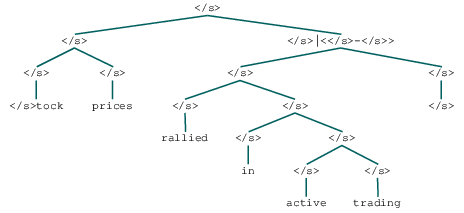

In [32]:
tree[0]

In [ ]:
predicted_tree[0]

In [ ]:
compare_trees(tree[0], predicted_tree[0])

In [ ]:
' '.join(tree[0].leaves())

* Improve parallelization through batch processing
* Implement CMY algorithm to reuse the computed values
* Preprocessing of tree (binary children, UNK words)

* check for this tree ('morgenzon has long been a special domain of afrikanerdom </s>')
* still missing word in compute_score_for_tree function. why? All preprocessign are good
* Other hyper parameters

* GPU usage

* Increase no. of units
* BEAM search
* Involve the classification of subcategories
* Assign different weights for different subcategories (atleast broader)

In [38]:
output = tf.gather([11,12,13,14,15,16,17,18,19,20],[[0,1],[1,2],[2,3],[3,4],[4,5]])
print(output)

tf.Tensor(
[[11 12]
 [12 13]
 [13 14]
 [14 15]
 [15 16]], shape=(5, 2), dtype=int32)


In [50]:
words = tf.nn.embedding_lookup(embeddings, treeDF_train.iat[0,0])
print(words.shape)
print(words[0:2])

(43, 10)
tf.Tensor(
[[ 9.5703125e-02 -3.8818359e-02  5.8837891e-02  3.9306641e-02
  -1.3000488e-02 -1.4843750e-01  7.5683594e-02 -1.3378906e-01
   2.8906250e-01  3.7078857e-03]
 [-1.0347366e-04  8.2492828e-05  1.5029907e-03  6.9046021e-04
   2.2983551e-04 -1.5487671e-03 -1.2435913e-03 -6.1035156e-04
   8.9645386e-04 -1.2893677e-03]], shape=(2, 10), dtype=float32)


In [47]:
output = tf.gather(words, [[[i], [i+1]] for i in range(0, words.shape[0]-1)], axis=0)
print(output.shape)
print(output[0])

tf.Tensor(
[[[ 9.5703125e-02 -3.8818359e-02  5.8837891e-02  3.9306641e-02
   -1.3000488e-02 -1.4843750e-01  7.5683594e-02 -1.3378906e-01
    2.8906250e-01  3.7078857e-03]]

 [[-1.0347366e-04  8.2492828e-05  1.5029907e-03  6.9046021e-04
    2.2983551e-04 -1.5487671e-03 -1.2435913e-03 -6.1035156e-04
    8.9645386e-04 -1.2893677e-03]]], shape=(2, 1, 10), dtype=float32)


In [49]:
tf.reshape(output[0], (2,10))

<tf.Tensor: id=4506393, shape=(2, 10), dtype=float32, numpy=
array([[ 9.5703125e-02, -3.8818359e-02,  5.8837891e-02,  3.9306641e-02,
        -1.3000488e-02, -1.4843750e-01,  7.5683594e-02, -1.3378906e-01,
         2.8906250e-01,  3.7078857e-03],
       [-1.0347366e-04,  8.2492828e-05,  1.5029907e-03,  6.9046021e-04,
         2.2983551e-04, -1.5487671e-03, -1.2435913e-03, -6.1035156e-04,
         8.9645386e-04, -1.2893677e-03]], dtype=float32)>